
# ALS signature using S-PrediXcan
***

In [20]:
from datetime import date
today = date.today()
date= today.strftime("%B %d, %Y")
import getpass
import os
cwd = os.getcwd()

In [19]:
print("Date: ", date)
print("")
print("Analysed by: ", getpass.getuser())
print("")
print("Current working directory: {0}".format(cwd))
print("")

Date:  August 11, 2022

Analysed by:  saezs

Current working directory: /gpfs/gsfs11/users/ALS_50k/SaraSaez_ALS/2022_01_06.ALS.DrugsRepositioning




# Workflow

***


<b>  (1) Download ALS GWAS summary Stats </b>  (Van Rheenen et al., 2021) __[Project Mine](https://surfdrive.surf.nl/files/index.php/s/E5RetKw10hC3jXy)__



     
       
<br> <b>   (2) S-PrediXcan Workflow </b>

            (2.1) ALS GWAS harmonization and formating
   

            (2.2) Imputation
   
         
            (2.3) Imputation post-processing
   
         
            (2.4) S-PrediXcan 
     
   
<br> <b>   (3) Built ALS signatures</b> with the up/dn- regulated gene 

<br> <b>   (4) Visualization</b> of the results


<br> 

<br> 
    
# Requiered files
***

   (1) ALS GWAS Summara Stas

       - /data/ADRD/2021_07_01.Methylation/COMBINED/meffil/*.idat

   (2) Downloaded S-PrediXcan files/ scripts</br>

       - original files: /data/ADRD/ipsc_qtl/analyses/genotypes/imputed/adrd_ipsc.imputed.bfile 
       


<div class="alert alert-block alert-info">

<b>Note:</b> Activate conda environment <b>projectsara3</b> for imputation from terminal! 
 
[Imputation](###-Imputation)

<br>


# Analysis

***

## Download the latest ALS GWAS (Van Rheenen et al., 2021)
The download is not working from EBI. Only works from Project Mine, but the direct link is not working so I downloaded to my laptop and transfered it to biowulf.

In [38]:
!pwd
!wget https://surfdrive.surf.nl/files/index.php/s/E5RetKw10hC3jXy/download?path=%2F&files=ALS_GWAS_RVB_SMR_sumstats.tar.g
# Descompress the file
! tar -xvf ALS_GWAS_RVB_SMR_sumstats.tar

/data/ALS_50k/SaraSaez_ALS/2022_01_06.ALS.DrugsRepositioning


In [27]:
%%bash
cat GWAS/ALS_sumstats_EUR_only.README
md5sum GWAS/ALS_sumstats_EUR_only.txt.gz
head GWAS/ALS_sumstats_EUR_only.txt
zcat GWAS/ALS_sumstats_EUR_only.txt.gz > GWAS/ALS_sumstats_EUR_only.txt
md5sum GWAS/ALS_sumstats_EUR_only.txt

# the checksum is fine!!! Van Rheenen just confirmed

van Rheenen W, van der Spek RAA, Bakker MK, et al (2021) Common and rare variant association analyses in Amyotrophic Lateral Sclerosis identify 15 risk loci with distinct genetic architectures and neuron-specific biology. medRxiv. doi: https://doi.org/10.1101/2021.03.12.21253159

These summary statistics describe the *European ancestries* meta-analysis GWAS.

filename: ALS_sumstats_EUR_only.txt.gz
md5sum: 4a515bfb365bbeda5599c846c00c38f7 

Field description:
rsid: The rsid of the variant
chromosome: The chromosome that the variant is located on (build hg19)
base_pair_location: The base pair location of the variant (build hg19)
effect_allele: The effect allele of the variant
other_allele: The non-effect allele
effect_allele_frequency: Frequency of the effect allele in total GWAS (cases and controls)
beta: The beta of the variant/trait association
standard_error: The standard error of the beta
p_value: The p-value of the variant/trait association
N_effective: effective sample size for va

## S-PrediXcan
### ALS GWAS harmonization and formatting
Using MetaXcan's built-in harmonization.

In [30]:
%%bash
cd /data/saezs/
. conda/etc/profile.d/conda.sh
conda activate projectsara3

python /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/MetaXcan-master/software/M03_betas.py \
--snp_map_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/coordinate_map/map_snp150_hg19.txt.gz \
--gwas_file /data/ALS_50k/SaraSaez_ALS/2022_01_06.ALS.DrugsRepositioning/GWAS/ALS_sumstats_EUR_only.txt.gz \
--snp_column rsid \
--non_effect_allele_column other_allele \
--effect_allele_column effect_allele \
--beta_column beta \
--pvalue_column p_value  \
--keep_non_rsid \
--throw \
--output /data/ALS_50k/SaraSaez_ALS/2022_01_06.ALS.DrugsRepositioning/ALS_ADDITIVE_quick.ALS_VanRheenen2021.gz


INFO - Processing GWAS command line parameters
INFO - Building beta for /data/ALS_50k/SaraSaez_ALS/2022_01_06.ALS.DrugsRepositioning/GWAS/ALS_sumstats_EUR_only.txt.gz and no database
INFO - Reading input gwas: /data/ALS_50k/SaraSaez_ALS/2022_01_06.ALS.DrugsRepositioning/GWAS/ALS_sumstats_EUR_only.txt.gz
INFO - Processing input gwas
INFO - Loading mapping
INFO - Mapping variants
INFO - Saving /data/ALS_50k/SaraSaez_ALS/2022_01_06.ALS.DrugsRepositioning/ALS_ADDITIVE_quick.ALS_VanRheenen2021.gz
INFO - Successfully ran GWAS input processing in 295.79866820108145 seconds


<div class="alert alert-block alert-warning">
<b> Alert! </b> harmonized GWAS has variants in hg38 version 
</div>


The quick harmonization I performed did not provide the formatted file needed for imputation, so I added this extra step.

In [36]:
%%bash
cd /data/ALS_50k/SaraSaez_ALS/2022_01_06.ALS.DrugsRepositioning/
zcat ALS_ADDITIVE_quick.ALS_VanRheenen2021.gz > ALS_ADDITIVE_quick.ALS_VanRheenen2021.txt


module load R/4.0.3
R --vanilla --no-save
library(data.table)
library(tidyverse)
library(dplyr)
data = fread("ALS_ADDITIVE_quick.ALS_VanRheenen2021.gz", header = T)
head(data)
data$sample_size = 138086
data$n_cases = 27205
data$effect_size = data$beta 
data$panel_variant_id = data$snp 
data$variant_id = data$gwas_snp 
data = data %>% separate(snp, c("chromosome", "position"), extra = "drop", fill = "right")
head(data)

#I need se and EAF so i need to open the original GWAS and take the info from there

data2 = fread("GWAS/ALS_sumstats_EUR_only.txt.gz", header = T)
head(data2)

data2$variant_id = data2$rsid
data2$frequency = data2$effect_allele_frequency
data2<- select(data2, variant_id, standard_error,frequency)
merged = merge(data, data2, by = "variant_id")


dataprint = select (merged, variant_id, panel_variant_id, chromosome, position, effect_allele, non_effect_allele, frequency, pvalue, zscore, effect_size, standard_error, sample_size, n_cases)
write.table(dataprint, "ALS.VanRheenen2021_quick.Formatted.harmonized.txt", quote = F, row.names = F, sep = " ")


R version 4.0.3 (2020-10-10) -- "Bunny-Wunnies Freak Out"
Copyright (C) 2020 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> library(data.table)
> library(tidyverse)
> library(dplyr)
> data = fread("ALS_ADDITIVE_quick.ALS_VanRheenen2021.gz", header = T)
> head(data)
      gwas_snp gwas_effect_allele gwas_non_effect_allele                 snp
1:  rs11240777                  A                      G chr1_863579_G_A_b38
2: 

[+] Loading gcc  9.2.0  ... 
[+] Loading GSL 2.6 for GCC 9.2.0 ...
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading openmpi 3.1.4  for GCC 9.2.0 
[+] Loading ImageMagick  7.0.8  on cn1085 
[+] Loading HDF5  1.10.4 
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading NetCDF 4.7.4_gcc9.2.0 
[+] Loading pandoc  2.16.2  on cn1085 
[+] Loading pcre2 10.21  ... 
[+] Loading R 4.0.3 
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpo

In [37]:
%%bash
module load samtools
bgzip ALS.VanRheenen2021_quick.Formatted.harmonized.txt

scp ALS.VanRheenen2021_quick.Formatted.harmonized.txt.gz /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/harmonized_gwas/


[+] Loading samtools 1.13  ... 


### Imputation
Run imputation from the terminal to active my conda environment

`cd /data/saezs/`

`. conda/etc/profile.d/conda.sh`

`conda activate projectsara3`

`swarm -f VR.ALS_20220203IMPUTATION_swarms -g 15 -t 24 --time 240:00:00 --logdir`

<div class="alert alert-block alert-success">
<b><i class="fa fa-lightbulb-o "></i>  Successful swarm job!
    
   jobID:29797127</b>
    
/data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Swarms_oe

</div>


In [8]:
%%bash
#check the output imputed files

cd  /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/summary_imputation_1000G/
ls VR.ALS.quick.harmo.YESfreq_chr* | wc -l
wc -l VR.ALS.quick.harmo.YESfreq_chr* 
scp VR.ALS.quick.harmo.YESfreq_chr* /data/ALS_50k/SaraSaez_ALS/2022_01_06.ALS.DrugsRepositioning/

220
     1850 VR.ALS.quick.harmo.YESfreq_chr10_sb0_reg0.1_ff0.01_by_region.txt.gz
     2506 VR.ALS.quick.harmo.YESfreq_chr10_sb1_reg0.1_ff0.01_by_region.txt.gz
     2089 VR.ALS.quick.harmo.YESfreq_chr10_sb2_reg0.1_ff0.01_by_region.txt.gz
     2726 VR.ALS.quick.harmo.YESfreq_chr10_sb3_reg0.1_ff0.01_by_region.txt.gz
     1820 VR.ALS.quick.harmo.YESfreq_chr10_sb4_reg0.1_ff0.01_by_region.txt.gz
     2165 VR.ALS.quick.harmo.YESfreq_chr10_sb5_reg0.1_ff0.01_by_region.txt.gz
     1705 VR.ALS.quick.harmo.YESfreq_chr10_sb6_reg0.1_ff0.01_by_region.txt.gz
     1721 VR.ALS.quick.harmo.YESfreq_chr10_sb7_reg0.1_ff0.01_by_region.txt.gz
     2051 VR.ALS.quick.harmo.YESfreq_chr10_sb8_reg0.1_ff0.01_by_region.txt.gz
     1969 VR.ALS.quick.harmo.YESfreq_chr10_sb9_reg0.1_ff0.01_by_region.txt.gz
     2530 VR.ALS.quick.harmo.YESfreq_chr11_sb0_reg0.1_ff0.01_by_region.txt.gz
     2331 VR.ALS.quick.harmo.YESfreq_chr11_sb1_reg0.1_ff0.01_by_region.txt.gz
     2404 VR.ALS.quick.harmo.YESfreq_chr11_sb2_reg0.1_ff0.01

In [2]:
%%bash
cd /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/harmonized_gwas
module load R/4.0.3
R --vanilla --no-save
library(data.table)
library(tidyverse)
library(dplyr)
data = fread("ALS.VanRheenen2021_quick.Formatted.harmonized.txt.gz", header = T)
write.table(data, "ALS.VanRheenen2021_quick.Formatted.harmonized.tabul.txt", quote = F, row.names = F, sep = "\t")


R version 4.0.3 (2020-10-10) -- "Bunny-Wunnies Freak Out"
Copyright (C) 2020 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> library(data.table)
> library(tidyverse)
> library(dplyr)
> data = fread("ALS.VanRheenen2021_quick.Formatted.harmonized.txt.gz", header = T)
> write.table(data, "ALS.VanRheenen2021_quick.Formatted.harmonized.tabul.txt", quote = F, row.names = F, sep = "\t")
> 


[+] Loading gcc  9.2.0  ... 
[+] Loading GSL 2.6 for GCC 9.2.0 ...
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading openmpi 3.1.4  for GCC 9.2.0 
[+] Loading ImageMagick  7.0.8  on cn0851 
[+] Loading HDF5  1.10.4 
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading NetCDF 4.7.4_gcc9.2.0 
[+] Loading pandoc  2.16.2  on cn0851 
[+] Loading pcre2 10.21  ... 
[+] Loading R 4.0.3 
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpo

In [5]:
%%bash
cd /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/harmonized_gwas
module load samtools
bgzip ALS.VanRheenen2021_quick.Formatted.harmonized.tabul.txt



[+] Loading samtools 1.13  ... 


### Imputation post-processing

In [7]:
%%bash
cd /data/saezs/
scp ALS.chr1-22_swarms /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Swarms
. conda/etc/profile.d/conda.sh
conda activate projectsara3
python /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/summary-gwas-imputation-master/src/gwas_summary_imputation_postprocess.py \
-gwas_file  /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/harmonized_gwas/ALS.VanRheenen2021_quick.Formatted.harmonized.tabul.txt.gz \
-folder /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/summary_imputation_1000G \
-pattern VR.ALS.quick.harmo* \
-parsimony 7 \
-output /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/processed_summary_imputation/imputed_VR.ALS.quick.harmo.YESfreq.txt.gz

INFO - Output exists. Nope.


In [8]:
%%bash
cd /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/
echo "How many available tissues do we have?" 
ls *.db | wc -l
ls
echo "How many available BRAIN tissues do we have?" 
ls *Brain*.db | wc -l
ls *Brain*.db

How many available tissues do we have?
49
mashr_Adipose_Subcutaneous.db
mashr_Adipose_Subcutaneous.txt.gz
mashr_Adipose_Visceral_Omentum.db
mashr_Adipose_Visceral_Omentum.txt.gz
mashr_Adrenal_Gland.db
mashr_Adrenal_Gland.txt.gz
mashr_Artery_Aorta.db
mashr_Artery_Aorta.txt.gz
mashr_Artery_Coronary.db
mashr_Artery_Coronary.txt.gz
mashr_Artery_Tibial.db
mashr_Artery_Tibial.txt.gz
mashr_Brain_Amygdala.db
mashr_Brain_Amygdala.txt.gz
mashr_Brain_Anterior_cingulate_cortex_BA24.db
mashr_Brain_Anterior_cingulate_cortex_BA24.txt.gz
mashr_Brain_Caudate_basal_ganglia.db
mashr_Brain_Caudate_basal_ganglia.txt.gz
mashr_Brain_Cerebellar_Hemisphere.db
mashr_Brain_Cerebellar_Hemisphere.txt.gz
mashr_Brain_Cerebellum.db
mashr_Brain_Cerebellum.txt.gz
mashr_Brain_Cortex.db
mashr_Brain_Cortex.txt.gz
mashr_Brain_Frontal_Cortex_BA9.db
mashr_Brain_Frontal_Cortex_BA9.txt.gz
mashr_Brain_Hippocampus.db
mashr_Brain_Hippocampus.txt.gz
mashr_Brain_Hypothalamus.db
mashr_Brain_Hypothalamus.txt.gz
mashr_Brain_Nucleus_ac

### S-PrediXcan

In [11]:
%%bash

cd /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS

echo "python /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/MetaXcan-master/software/SPrediXcan.py --gwas_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/processed_summary_imputation/imputed_VR.ALS.quick.harmo.YESfreq.txt.gz --snp_column panel_variant_id --effect_allele_column effect_allele --non_effect_allele_column non_effect_allele --zscore_column zscore --model_db_path /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Whole_Blood.db --covariance /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Whole_Blood.txt.gz --keep_non_rsid --additional_output --model_db_snp_key varID --throw --output_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Whole_Blood.csv
python /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/MetaXcan-master/software/SPrediXcan.py --gwas_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/processed_summary_imputation/imputed_VR.ALS.quick.harmo.YESfreq.txt.gz --snp_column panel_variant_id --effect_allele_column effect_allele --non_effect_allele_column non_effect_allele --zscore_column zscore --model_db_path /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Amygdala.db --covariance /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Amygdala.txt.gz --keep_non_rsid --additional_output --model_db_snp_key varID --throw --output_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Amygdala.csv
python /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/MetaXcan-master/software/SPrediXcan.py --gwas_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/processed_summary_imputation/imputed_VR.ALS.quick.harmo.YESfreq.txt.gz --snp_column panel_variant_id --effect_allele_column effect_allele --non_effect_allele_column non_effect_allele --zscore_column zscore --model_db_path /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Anterior_cingulate_cortex_BA24.db --covariance /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Anterior_cingulate_cortex_BA24.txt.gz --keep_non_rsid --additional_output --model_db_snp_key varID --throw --output_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Anterior_cingulate_cortex_BA24.csv
python /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/MetaXcan-master/software/SPrediXcan.py --gwas_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/processed_summary_imputation/imputed_VR.ALS.quick.harmo.YESfreq.txt.gz --snp_column panel_variant_id --effect_allele_column effect_allele --non_effect_allele_column non_effect_allele --zscore_column zscore --model_db_path /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Caudate_basal_ganglia.db --covariance /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Caudate_basal_ganglia.txt.gz --keep_non_rsid --additional_output --model_db_snp_key varID --throw --output_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Caudate_basal_ganglia.csv
python /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/MetaXcan-master/software/SPrediXcan.py --gwas_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/processed_summary_imputation/imputed_VR.ALS.quick.harmo.YESfreq.txt.gz --snp_column panel_variant_id --effect_allele_column effect_allele --non_effect_allele_column non_effect_allele --zscore_column zscore --model_db_path /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Cerebellar_Hemisphere.db --covariance /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Cerebellar_Hemisphere.txt.gz --keep_non_rsid --additional_output --model_db_snp_key varID --throw --output_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Cerebellar_Hemisphere.csv
python /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/MetaXcan-master/software/SPrediXcan.py --gwas_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/processed_summary_imputation/imputed_VR.ALS.quick.harmo.YESfreq.txt.gz --snp_column panel_variant_id --effect_allele_column effect_allele --non_effect_allele_column non_effect_allele --zscore_column zscore --model_db_path /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Cerebellum.db --covariance /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Cerebellum.txt.gz --keep_non_rsid --additional_output --model_db_snp_key varID --throw --output_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Cerebellum.csv
python /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/MetaXcan-master/software/SPrediXcan.py --gwas_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/processed_summary_imputation/imputed_VR.ALS.quick.harmo.YESfreq.txt.gz --snp_column panel_variant_id --effect_allele_column effect_allele --non_effect_allele_column non_effect_allele --zscore_column zscore --model_db_path /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Cortex.db --covariance /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Cortex.txt.gz --keep_non_rsid --additional_output --model_db_snp_key varID --throw --output_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Cortex.csv
python /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/MetaXcan-master/software/SPrediXcan.py --gwas_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/processed_summary_imputation/imputed_VR.ALS.quick.harmo.YESfreq.txt.gz --snp_column panel_variant_id --effect_allele_column effect_allele --non_effect_allele_column non_effect_allele --zscore_column zscore --model_db_path /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Frontal_Cortex_BA9.db --covariance /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Frontal_Cortex_BA9.txt.gz --keep_non_rsid --additional_output --model_db_snp_key varID --throw --output_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Frontal_Cortex_BA9.csv
python /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/MetaXcan-master/software/SPrediXcan.py --gwas_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/processed_summary_imputation/imputed_VR.ALS.quick.harmo.YESfreq.txt.gz --snp_column panel_variant_id --effect_allele_column effect_allele --non_effect_allele_column non_effect_allele --zscore_column zscore --model_db_path /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Hippocampus.db --covariance /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Hippocampus.txt.gz --keep_non_rsid --additional_output --model_db_snp_key varID --throw --output_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.harmo.YESfreq_PM_Brain_Hippocampus.csv
python /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/MetaXcan-master/software/SPrediXcan.py --gwas_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/processed_summary_imputation/imputed_VR.ALS.quick.harmo.YESfreq.txt.gz --snp_column panel_variant_id --effect_allele_column effect_allele --non_effect_allele_column non_effect_allele --zscore_column zscore --model_db_path /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Hypothalamus.db --covariance /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Hypothalamus.txt.gz --keep_non_rsid --additional_output --model_db_snp_key varID --throw --output_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Hypothalamus.csv
python /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/MetaXcan-master/software/SPrediXcan.py --gwas_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/processed_summary_imputation/imputed_VR.ALS.quick.harmo.YESfreq.txt.gz --snp_column panel_variant_id --effect_allele_column effect_allele --non_effect_allele_column non_effect_allele --zscore_column zscore --model_db_path /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Nucleus_accumbens_basal_ganglia.db --covariance /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Nucleus_accumbens_basal_ganglia.txt.gz --keep_non_rsid --additional_output --model_db_snp_key varID --throw --output_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Nucleus_accumbens_basal_ganglia.csv
python /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/MetaXcan-master/software/SPrediXcan.py --gwas_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/processed_summary_imputation/imputed_VR.ALS.quick.harmo.YESfreq.txt.gz --snp_column panel_variant_id --effect_allele_column effect_allele --non_effect_allele_column non_effect_allele --zscore_column zscore --model_db_path /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Putamen_basal_ganglia.db --covariance /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Putamen_basal_ganglia.txt.gz --keep_non_rsid --additional_output --model_db_snp_key varID --throw --output_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Putamen_basal_ganglia.csv
python /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/MetaXcan-master/software/SPrediXcan.py --gwas_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/processed_summary_imputation/imputed_VR.ALS.quick.harmo.YESfreq.txt.gz --snp_column panel_variant_id --effect_allele_column effect_allele --non_effect_allele_column non_effect_allele --zscore_column zscore --model_db_path /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Spinal_cord_cervical_c-1.db --covariance /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Spinal_cord_cervical_c-1.txt.gz --keep_non_rsid --additional_output --model_db_snp_key varID --throw --output_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Spinal_cord_cervical_c-1.csv
python /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/MetaXcan-master/software/SPrediXcan.py --gwas_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/processed_summary_imputation/imputed_VR.ALS.quick.harmo.YESfreq.txt.gz --snp_column panel_variant_id --effect_allele_column effect_allele --non_effect_allele_column non_effect_allele --zscore_column zscore --model_db_path /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Substantia_nigra.db --covariance /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Substantia_nigra.txt.gz --keep_non_rsid --additional_output --model_db_snp_key varID --throw --output_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Substantia_nigra.csv
python /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/MetaXcan-master/software/SPrediXcan.py --gwas_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/processed_summary_imputation/imputed_VR.ALS.quick.harmo.YESfreq.txt.gz --snp_column panel_variant_id --effect_allele_column effect_allele --non_effect_allele_column non_effect_allele --zscore_column zscore --model_db_path /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Muscle_Skeletal.db --covariance /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Muscle_Skeletal.txt.gz --keep_non_rsid --additional_output --model_db_snp_key varID --throw --output_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Muscle_Skeletal.csv" > Spredixcan.VR.ALS.15tissues_swarms

swarm -f Spredixcan.VR.ALS.15tissues_swarms -g 150 -t 24 --time 240:00:00 --logdir /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Swarms_oe

29847738


mkdir: cannot create directory ‘VR2021.ALS’: File exists


### Run MetaXcan (Additional)
These has to be done from the terminal

In [ ]:
cd /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/smetaxcan/
mkdir VR2021.ALS
cd /data/saezs/
. conda/etc/profile.d/conda.sh
conda activate projectsara3


python /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/MetaXcan-master/software/SMulTiXcan.py \
--models_folder /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/tometa \
--models_name_pattern "mashr_(.*).db" \
--snp_covariance /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/gtex_v8_expression_mashr_snp_smultixcan_covariance.txt.gz \
--metaxcan_folder /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS \
--metaxcan_filter "VR.ALS.quick.harmo.YESfreq_PM_Brain_(.*).csv" \
--metaxcan_file_name_parse_pattern "(.*)_PM_(.*).csv" \
--gwas_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/processed_summary_imputation/imputed_VR.ALS.quick.harmo.YESfreq.txt.gz \
--snp_column panel_variant_id \
--effect_allele_column effect_allele \
--non_effect_allele_column non_effect_allele \
--zscore_column zscore \
--keep_non_rsid \
--model_db_snp_key varID \
--cutoff_condition_number 30 \
--verbosity 7 \
--throw \
--output /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/smetaxcan/VR2021.ALS/VR.ALS.quick.harmo.smultixcan.txt


In [ ]:
# log file
INFO - Creating context
INFO - Creating MetaXcan results manager
Level 9 - Loading metaxcan /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Amygdala.csv
Level 9 - Loading metaxcan /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Anterior_cingulate_cortex_BA24.csv
Level 9 - Loading metaxcan /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Caudate_basal_ganglia.csv
Level 9 - Loading metaxcan /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Cerebellar_Hemisphere.csv
Level 9 - Loading metaxcan /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Cerebellum.csv
Level 9 - Loading metaxcan /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Cortex.csv
Level 9 - Loading metaxcan /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Frontal_Cortex_BA9.csv
Level 9 - Loading metaxcan /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Hypothalamus.csv
Level 9 - Loading metaxcan /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Nucleus_accumbens_basal_ganglia.csv
Level 9 - Loading metaxcan /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Putamen_basal_ganglia.csv
Level 9 - Loading metaxcan /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Spinal_cord_cervical_c-1.csv
Level 9 - Loading metaxcan /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Substantia_nigra.csv
Level 9 - Building data
Level 9 - Processing Brain_Amygdala
Level 9 - Processing Brain_Anterior_cingulate_cortex_BA24
Level 9 - Processing Brain_Caudate_basal_ganglia
Level 9 - Processing Brain_Cerebellar_Hemisphere
Level 9 - Processing Brain_Cerebellum
Level 9 - Processing Brain_Cortex
Level 9 - Processing Brain_Frontal_Cortex_BA9
Level 9 - Processing Brain_Hypothalamus
Level 9 - Processing Brain_Nucleus_accumbens_basal_ganglia
Level 9 - Processing Brain_Putamen_basal_ganglia
Level 9 - Processing Brain_Spinal_cord_cervical_c-1
Level 9 - Processing Brain_Substantia_nigra
INFO - Loading genes
INFO - Context for snp covariance
INFO - Assessing GWAS-Models SNP intersection
INFO - Processing GWAS command line parameters
INFO - Reading input gwas: /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/processed_summary_imputation/imputed_VR.ALS.quick.harmo.YESfreq.txt.gz
INFO - Processing input gwas
Level 9 - Using declared zscore
Level 9 - loading /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/tometa/mashr_Brain_Amygdala.db
Level 9 - loading /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/tometa/mashr_Brain_Anterior_cingulate_cortex_BA24.db
Level 9 - loading /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/tometa/mashr_Brain_Caudate_basal_ganglia.db
Level 9 - loading /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/tometa/mashr_Brain_Cerebellar_Hemisphere.db
Level 9 - loading /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/tometa/mashr_Brain_Cerebellum.db
Level 9 - loading /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/tometa/mashr_Brain_Cortex.db
Level 9 - loading /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/tometa/mashr_Brain_Frontal_Cortex_BA9.db
Level 9 - loading /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/tometa/mashr_Brain_Hippocampus.db
Level 9 - loading /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/tometa/mashr_Brain_Hypothalamus.db
Level 9 - loading /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/tometa/mashr_Brain_Nucleus_accumbens_basal_ganglia.db
Level 9 - loading /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/tometa/mashr_Brain_Putamen_basal_ganglia.db
Level 9 - loading /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/tometa/mashr_Brain_Spinal_cord_cervical_c-1.db
Level 9 - loading /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/tometa/mashr_Brain_Substantia_nigra.db
Level 9 - loading /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/tometa/mashr_Muscle_Skeletal.db
Level 9 - loading /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/tometa/mashr_Whole_Blood.db
INFO - Loading Model Manager
Level 9 - preloading models
Level 9 - processing Brain_Amygdala
Level 9 - processing Brain_Anterior_cingulate_cortex_BA24
Level 9 - processing Brain_Caudate_basal_ganglia
Level 9 - processing Brain_Cerebellar_Hemisphere
Level 9 - processing Brain_Cerebellum
Level 9 - processing Brain_Cortex
Level 9 - processing Brain_Frontal_Cortex_BA9
Level 9 - processing Brain_Hippocampus
Level 9 - processing Brain_Hypothalamus
Level 9 - processing Brain_Nucleus_accumbens_basal_ganglia
Level 9 - processing Brain_Putamen_basal_ganglia
Level 9 - processing Brain_Spinal_cord_cervical_c-1
Level 9 - processing Brain_Substantia_nigra
Level 9 - processing Muscle_Skeletal
Level 9 - processing Whole_Blood
Level 9 - preparing models (dictionary layout)
INFO - Preparing SNP covariance
INFO - Processing
Level 7 - Gene 1/19359: ENSG00000169583.12Level 7 - Gene 19169/19359: ENSG00000172005.10
..................
Level 7 - Gene 19169/19359: ENSG00000172005.10
INFO - Ran multi tissue in 417.05443964898586 seconds

## Built the list of up/dn- regulated genes from SPINAL CORD

In [6]:
%%bash
cd /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/
module load R/4.1.0
R --vanilla --no-save
# Load libraries
library(data.table)
library(tidyverse)
library(ggplot2)
library(dplyr)
library(RColorBrewer)
library('org.Hs.eg.db')
columns(org.Hs.eg.db)

data = fread("VR.ALS.quick.harmo.YESfreq_PM_Brain_Spinal_cord_cervical_c-1.csv", header=T)
head(data)
raw.pvalue = data$pvalue
Padj.FDR = p.adjust(raw.pvalue, method = "fdr")
print = cbind(data, Padj.FDR)
write.csv(print, "VR.ALS.quick.harmo_Brain_Spinal_cord_cervical_c-1.FDR.csv")

print <- filter(print, Padj.FDR < 0.05)
print$Signature[print$zscore > 0] = "UP"
print$Signature[print$zscore < 0] = "DN"
UP = filter(print, zscore > 0)
print(UP)
dim(UP)
DN = filter(print, zscore < 0)
print(DN)
dim(DN)
print$Signature[print$zscore > 0] = "UP"
print$Signature[print$zscore < 0] = "DN"
print <- dplyr::select(print, gene,gene_name,zscore, pvalue, Padj.FDR)
write.table(print, "ALS.SpinalCord.Signature", col.names = T, row.names = F, quote = F, sep = "\t")


### Additional step to map gene to chr and pos

# Annotation based on ENCODE v41
ann <- fread("/gpfs/gsfs11/users/ALS_50k/SaraSaez_ALS/2022_01_06.ALS.DrugsRepositioning/gencode.v41_gene_annotation_table.txt", header = T)
head(ann)

ann <- dplyr::select(ann, gene = Geneid,
                    gene_name = GeneSymbol,
                  Chromosome, Start, End, Class)


ann$chr <- gsub('chr', '', ann$Chromosome)
ann$chr <- as.numeric(ann$chr)
data = read.csv("VR.ALS.quick.harmo_Brain_Spinal_cord_cervical_c-1.FDR.csv", header = T)

merged <- merge(ann, data, by= "gene_name")
dim(merged)
head(merged)
write.table(merged, "ALL.ALS.SpinalCord.Signature.Ann.ENCODEv41.hg38.tab", col.names = T, row.names = F, quote = F, sep = "\t")


highlight = filter(merged, Padj.FDR < 0.05)
head(highlight)
dim(highlight)
### Two genes are not annotated, so I do that manually 
highlightup <- filter(highlight, zscore > 0)
head(highlightup)

addup <- data.frame("gene_name" = "RP11-452H21.4",
                 "zscore" = 4.099915981,
                   "chr" = 11,
                 "Chromosome" = "chr11",
                 "pvalue" = 4.13E-05,
                 "Padj.FDR" = 3.04E-02,
                 "Start" = 78423982)
head(addup)
highlightup <- bind_rows(highlightup, addup)
head(highlightup)

highlightdn <- filter(highlight, zscore < 0)
adddn <- data.frame("gene_name" = "SEPTIN8",
                 "zscore" = -4.38,
                 "chr" = 5,
                 "Chromosome" = "chr5",
                 "pvalue" = 1.20E-05,
                 "Padj.FDR" = 0.012987156,
                 "Start" = 132750819)
highlightdn <-dplyr::bind_rows(highlightdn, adddn)
highlightdn$Signature = "DN"
highlightup$Signature = "UP"
binded <- rbind(highlightdn,highlightup)
head(binded)
binded <- dplyr::select(binded,gene_name,
                        gene = gene.x,
                        Chromosome,
                        Start,
                        End,    
                        Class,
                        zscore,
                        pvalue,
                        Padj.FDR,
                        Signature)
write.table(binded, "ALS.SpinalCord.Signature.Ann.ENCODEv41.hg38.tab", col.names = T, row.names = F, quote = F, sep = "\t")


[+] Loading gcc  9.2.0  ... 
[+] Loading GSL 2.6 for GCC 9.2.0 ...
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading openmpi 4.0.5  for GCC 9.2.0 
[+] Loading ImageMagick  7.0.8  on cn4273 
[+] Loading HDF5  1.10.4 
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading NetCDF 4.7.4_gcc9.2.0 
[+] Loading pandoc  2.17.1.1  on cn4273 
[+] Loading pcre2 10.21  ... 
[+] Loading R 4.1.0 



R version 4.1.0 (2021-05-18) -- "Camp Pontanezen"
Copyright (C) 2021 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> # Load libraries
> library(data.table)
> library(tidyverse)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()


> library(ggplot2)
> library(dplyr)
> library(RColorBrewer)
> library('org.Hs.eg.db')


Loading required package: AnnotationDbi
Loading required package: stats4
Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min

Loading required package: Biobase
Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pk

> columns(org.Hs.eg.db)
 [1] "ACCNUM"       "ALIAS"        "ENSEMBL"      "ENSEMBLPROT"  "ENSEMBLTRANS"
 [6] "ENTREZID"     "ENZYME"       "EVIDENCE"     "EVIDENCEALL"  "GENENAME"    
[11] "GENETYPE"     "GO"           "GOALL"        "IPI"          "MAP"         
[16] "OMIM"         "ONTOLOGY"     "ONTOLOGYALL"  "PATH"         "PFAM"        
[21] "PMID"         "PROSITE"      "REFSEQ"       "SYMBOL"       "UCSCKG"      
[26] "UNIPROT"     
> 
> data = fread("VR.ALS.quick.harmo.YESfreq_PM_Brain_Spinal_cord_cervical_c-1.csv", header=T)
> head(data)
                 gene gene_name    zscore effect_size       pvalue       var_g
1: ENSG00000147894.14   C9orf72  9.748719          NA 1.868103e-22 0.126112990
2: ENSG00000211445.11      GPX3 -5.179410          NA 2.225888e-07 0.006669466
3:  ENSG00000278311.4    GGNBP2  4.949284          NA 7.448697e-07 0.030894464
4:  ENSG00000241404.6     EGFL8 -4.720776          NA 2.349463e-06 0.005837292
5:  ENSG00000156232.7     WHAMM -4.704102          N

Warning message:
NAs introduced by coercion 


> data = read.csv("VR.ALS.quick.harmo_Brain_Spinal_cord_cervical_c-1.FDR.csv", header = T)
> 
> merged <- merge(ann, data, by= "gene_name")
> dim(merged)
[1] 11042    22
> head(merged)
   gene_name             gene.x Chromosome     Start       End          Class
1:       A2M ENSG00000175899.15      chr12   9067664   9116229 protein_coding
2:     A2ML1 ENSG00000166535.20      chr12   8822621   8887001 protein_coding
3:   A3GALT2  ENSG00000184389.9       chr1  33306766  33321098 protein_coding
4:    A4GALT ENSG00000128274.17      chr22  42692121  42721298 protein_coding
5:     A4GNT  ENSG00000118017.4       chr3 138123713 138132390 protein_coding
6:      AACS ENSG00000081760.17      chr12 125065434 125143333 protein_coding
   chr     X             gene.y     zscore effect_size     pvalue        var_g
1:  12  9109 ENSG00000175899.14  0.3737197          NA 0.70861285 0.0031651974
2:  12  4540 ENSG00000166535.19  0.9832183          NA 0.32550000 0.0001518668
3:   1  1081  ENSG00000184389.9 

In [5]:
%%bash
# From https://www.biostars.org/p/140471/
wget https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_41/gencode.v41.annotation.gtf.gz
zcat gencode.v41.annotation.gtf.gz | awk 'BEGIN{FS="\t"}{split($9,a,";"); if($3~"gene") print a[1]"\t"a[3]"\t"$1":"$4"-"$5"\t"a[2]"\t"$7}' |sed 's/gene_id "//' | sed 's/gene_id "//' | sed 's/gene_type "//'| sed 's/gene_name "//' | sed 's/"//g' | awk 'BEGIN{FS="\t"}{split($3,a,"[:-]"); print $1"\t"$2"\t"a[1]"\t"a[2]"\t"a[3]"\t"$4"\t"$5"\t"a[3]-a[2];}' | 
sed "1i\Geneid\tGeneSymbol\tChromosome\tStart\tEnd\tClass\tStrand\tLength"  > gencode.v41_gene_annotation_table.txt

--2022-08-11 11:06:10--  https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_41/gencode.v41.annotation.gtf.gz
Resolving dtn05-e0 (dtn05-e0)... 10.1.200.241
Connecting to dtn05-e0 (dtn05-e0)|10.1.200.241|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 49042889 (47M) [application/x-gzip]
Saving to: ‘gencode.v41.annotation.gtf.gz.2’

     0K .......... .......... .......... .......... ..........  0%  311K 2m34s
    50K .......... .......... .......... .......... ..........  0%  654K 1m54s
   100K .......... .......... .......... .......... ..........  0% 4.71M 79s
   150K .......... .......... .......... .......... ..........  0% 1.47M 67s
   200K .......... .......... .......... .......... ..........  0% 1.22M 61s
   250K .......... .......... .......... .......... ..........  0% 9.26M 52s
   300K .......... .......... .......... .......... ..........  0% 11.0M 45s
   350K .......... .......... .......... .......... ..........  0% 9.45M 40s
   40

In [99]:
import pandas as pd
df = pd.read_csv('/data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/ALS.SpinalCord.Signature.Ann.ENCODEv41.hg38.tab', sep="\t")
display(df)

,gene_name,gene,Chromosome,Start,End,Class,zscore,pvalue,Padj.FDR,Signature
0,CAMLG,ENSG00000164615.6,chr5,134738495,134752157.0,protein_coding,-4.181764,2.892567e-05,2.409316e-02,DN
1,DGKQ,ENSG00000145214.14,chr4,958887,986895.0,protein_coding,-4.411177,1.028103e-05,1.298716e-02,DN
2,DHRS11,ENSG00000278535.5,chr17,36591879,36600804.0,protein_coding,-4.359433,1.304000e-05,1.298716e-02,DN
3,DLST,ENSG00000119689.15,chr14,74881891,74903743.0,protein_coding,-4.422866,9.740000e-06,1.298716e-02,DN
4,DUS2,ENSG00000167264.18,chr16,67987746,68079320.0,protein_coding,-3.919053,8.889754e-05,4.637298e-02,DN
5,EGFL8,ENSG00000241404.7,chr6,32164595,32168281.0,protein_coding,-4.720776,2.349463e-06,6.371580e-03,DN
6,GPX3,ENSG00000211445.13,chr5,151020591,151028988.0,protein_coding,-5.179410,2.225888e-07,1.390512e-03,DN
7,MPDU1,ENSG00000129255.16,chr17,7583529,7592789.0,protein_coding,-4.001208,6.301998e-05,3.936858e-02,DN
8,MYO19,ENSG00000278259.5,chr17,36495636,36543435.0,protein_coding,-3.902619,9.515746e-05,4.637298e-02,DN
9,NARS2,ENSG00000137513.11,chr11,78435620,78575194.0,protein_coding,-3.881755,1.037054e-04,4.637298e-02,DN


In [98]:
%%bash

cd /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/
module load R/4.1.0
R --vanilla --no-save
# Load libraries
require(data.table)
require(tidyverse)
require(dplyr)
require(ggplot2)
library(gplots)
library(ggpubr)
library(cowplot)
library(svglite)
library(ggrepel)

data = fread("/data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/ALL.ALS.SpinalCord.Signature.Ann.ENCODEv41.hg38.tab", header = T)
head(data)

highlight = filter(data, Padj.FDR < 0.05)
head(highlight)
dim(highlight)
highlightup <- filter(highlight, zscore > 0)
dim(highlightup)
highlightdn <- filter(highlight, zscore < 0)
dim(highlightdn)
binded <- rbind(highlightdn, highlightup)
snpsOfInterest <- binded$gene_name

library(qqman)
d <- dplyr::select(data,SNP = gene_name,
                        CHR = chr,
                        BP = Start,
                        zscore = zscore)
d <- data.frame(d)
svg("rplot.svg")
#png("rplot.png", width = 1200, height = 600)
d$CHR <- as.numeric(d$CHR)

manhattan(d,p = "zscore", logp = FALSE, ylab = "Z-score", genomewideline = FALSE,
    col = c("grey80", "grey90"), 
    ylim=c(-6,10),suggestiveline = FALSE, highlight = snpsOfInterest)

dev.off()

ASHJDAFDJSK
manhattanS(d, p = "zscore", logp = FALSE, ylab = "Z-score", genomewideline = FALSE, 
    suggestiveline = FALSE,)

ggsave("qqman.png", plot = last_plot(), width = 11, height = 5, units = "in", dpi = 300) 


p <- ggplot(d, aes(chr, zscore))
 
 
p2 = p + geom_jitter(size = 0.4, width = 0.45, alpha = 0.5, color = "gray", show.legend = FALSE) + geom_text_repel(size=3.3, color = 'maroon', data=subset(highlightup),
                                                                       aes(chr, zscore,label=gene_name), check_overlap = TRUE) +
                                geom_hline(yintercept=0,color = "white", size=2) +
geom_text_repel(size=3.5, color = 'skyblue4', data=subset(highlightdn), aes(chr, zscore,label=gene_name), check_overlap = TRUE) +  
  geom_point(data=highlightup, aes(chr, zscore), colour="black", size=3,shape = 21, colour = "black", fill = "maroon") +
  geom_point(data=highlightdn, aes(chr, zscore), colour="black", size=3,shape = 21, colour = "black", fill = "skyblue4") +
  theme(legend.position = "none", axis.title.x = element_text(size = 18),axis.title.y = element_text(size = 18),  panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black"), axis.text.y = element_text(size = 12), axis.text.x = element_text(size = 12)) + 
  xlim ("1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20","21","22") +
labs(x = "Chromosome", y = "Z-score")

ggsave("SpinalCord.c1.VR.ALS.onlyFDR.nocolor.png", plot = p2, width = 11, height = 5, units = "in", dpi = 300)



[+] Loading gcc  9.2.0  ... 
[+] Loading GSL 2.6 for GCC 9.2.0 ...
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading openmpi 4.0.5  for GCC 9.2.0 
[+] Loading ImageMagick  7.0.8  on cn4273 
[+] Loading HDF5  1.10.4 
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading NetCDF 4.7.4_gcc9.2.0 
[+] Loading pandoc  2.17.1.1  on cn4273 
[+] Loading pcre2 10.21  ... 
[+] Loading R 4.1.0 



R version 4.1.0 (2021-05-18) -- "Camp Pontanezen"
Copyright (C) 2021 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> # Load libraries
> require(data.table)


Loading required package: data.table


> require(tidyverse)


Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()


> require(dplyr)
> require(ggplot2)
> library(gplots)



Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



> library(ggpubr)
> library(cowplot)



Attaching package: ‘cowplot’

The following object is masked from ‘package:ggpubr’:

    get_legend



> library(svglite)
> library(ggrepel)
> 
> data = fread("/data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/ALL.ALS.SpinalCord.Signature.Ann.ENCODEv41.hg38.tab", header = T)
> head(data)
   gene_name             gene.x Chromosome     Start       End          Class
1:       A2M ENSG00000175899.15      chr12   9067664   9116229 protein_coding
2:     A2ML1 ENSG00000166535.20      chr12   8822621   8887001 protein_coding
3:   A3GALT2  ENSG00000184389.9       chr1  33306766  33321098 protein_coding
4:    A4GALT ENSG00000128274.17      chr22  42692121  42721298 protein_coding
5:     A4GNT  ENSG00000118017.4       chr3 138123713 138132390 protein_coding
6:      AACS ENSG00000081760.17      chr12 125065434 125143333 protein_coding
   chr     X             gene.y     zscore effect_size     pvalue        var_g
1:  12  9109 ENSG00000175899.14  0.3737197          NA 0.70861285 0.0031651974
2:  12  4540 ENSG00000166535.19  0.9832183    


For example usage please run: vignette('qqman')

Citation appreciated but not required:
Turner, (2018). qqman: an R package for visualizing GWAS results using Q-Q and manhattan plots. Journal of Open Source Software, 3(25), 731, https://doi.org/10.21105/joss.00731.


Attaching package: ‘qqman’

The following object is masked _by_ ‘.GlobalEnv’:

    snpsOfInterest



> d <- dplyr::select(data,SNP = gene_name,
+                         CHR = chr,
+                         BP = Start,
+                         zscore = zscore)
> d <- data.frame(d)
> svg("rplot.svg")
> #png("rplot.png", width = 1200, height = 600)
> d$CHR <- as.numeric(d$CHR)
> 
> manhattan(d,p = "zscore", logp = FALSE, ylab = "Z-score", genomewideline = FALSE,
+     col = c("grey80", "grey90"), 
+     ylim=c(-6,10),suggestiveline = FALSE, highlight = snpsOfInterest)
> 
> dev.off()
null device 
          1 
> 
> ASHJDAFDJSK


Error: object 'ASHJDAFDJSK' not found
Execution halted


CalledProcessError: Command 'b'\ncd /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/\nmodule load R/4.1.0\nR --vanilla --no-save\n# Load libraries\nrequire(data.table)\nrequire(tidyverse)\nrequire(dplyr)\nrequire(ggplot2)\nlibrary(gplots)\nlibrary(ggpubr)\nlibrary(cowplot)\nlibrary(svglite)\nlibrary(ggrepel)\n\ndata = fread("/data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/ALL.ALS.SpinalCord.Signature.Ann.ENCODEv41.hg38.tab", header = T)\nhead(data)\n\nhighlight = filter(data, Padj.FDR < 0.05)\nhead(highlight)\ndim(highlight)\nhighlightup <- filter(highlight, zscore > 0)\ndim(highlightup)\nhighlightdn <- filter(highlight, zscore < 0)\ndim(highlightdn)\nbinded <- rbind(highlightdn, highlightup)\nsnpsOfInterest <- binded$gene_name\n\nlibrary(qqman)\nd <- dplyr::select(data,SNP = gene_name,\n                        CHR = chr,\n                        BP = Start,\n                        zscore = zscore)\nd <- data.frame(d)\nsvg("rplot.svg")\n#png("rplot.png", width = 1200, height = 600)\nd$CHR <- as.numeric(d$CHR)\n\nmanhattan(d,p = "zscore", logp = FALSE, ylab = "Z-score", genomewideline = FALSE,\n    col = c("grey80", "grey90"), \n    ylim=c(-6,10),suggestiveline = FALSE, highlight = snpsOfInterest)\n\ndev.off()\n\nASHJDAFDJSK\nmanhattanS(d, p = "zscore", logp = FALSE, ylab = "Z-score", genomewideline = FALSE, \n    suggestiveline = FALSE,)\n\nggsave("qqman.png", plot = last_plot(), width = 11, height = 5, units = "in", dpi = 300) \n\n\np <- ggplot(d, aes(chr, zscore))\n \n \np2 = p + geom_jitter(size = 0.4, width = 0.45, alpha = 0.5, color = "gray", show.legend = FALSE) + geom_text_repel(size=3.3, color = \'maroon\', data=subset(highlightup),\n                                                                       aes(chr, zscore,label=gene_name), check_overlap = TRUE) +\n                                geom_hline(yintercept=0,color = "white", size=2) +\ngeom_text_repel(size=3.5, color = \'skyblue4\', data=subset(highlightdn), aes(chr, zscore,label=gene_name), check_overlap = TRUE) +  \n  geom_point(data=highlightup, aes(chr, zscore), colour="black", size=3,shape = 21, colour = "black", fill = "maroon") +\n  geom_point(data=highlightdn, aes(chr, zscore), colour="black", size=3,shape = 21, colour = "black", fill = "skyblue4") +\n  theme(legend.position = "none", axis.title.x = element_text(size = 18),axis.title.y = element_text(size = 18),  panel.grid.major = element_blank(), panel.grid.minor = element_blank(),\n        panel.background = element_blank(), axis.line = element_line(colour = "black"), axis.text.y = element_text(size = 12), axis.text.x = element_text(size = 12)) + \n  xlim ("1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20","21","22") +\nlabs(x = "Chromosome", y = "Z-score")\n\nggsave("SpinalCord.c1.VR.ALS.onlyFDR.nocolor.png", plot = p2, width = 11, height = 5, units = "in", dpi = 300)\n\n'' returned non-zero exit status 1.

In [107]:
%%bash

cd /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/
module load R/4.1.0
R --vanilla --no-save
# Load libraries
require(data.table)
require(tidyverse)
require(dplyr)
require(ggplot2)
library(gplots)
library(ggpubr)
library(cowplot)
library(svglite)
library(ggrepel)
data0 = fread("/data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/ALL.ALS.SpinalCord.Signature.Ann.ENCODEv41.hg38.tab", header = T)

data = fread("/data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/trial.csv", header = T)
head(data)

highlight = filter(data, Padj.FDR < 0.05)
head(highlight)
dim(highlight)
highlightup <- filter(highlight, zscore > 0)
dim(highlightup)
highlightdn <- filter(highlight, zscore < 0)
dim(highlightdn)

d <- as.data.frame(data0)
p <- ggplot(d, aes(chr, zscore))
 
 
p2 = p + geom_jitter(size = 0.4, width = 0.45, alpha = 0.5, color = "gray", show.legend = FALSE) + geom_text_repel(size=3.3, color = 'maroon', data=subset(highlightup),
                                                                       aes(chr, zscore,label=gene_name), check_overlap = TRUE) +
                                geom_hline(yintercept=0,color = "white", size=2) +
geom_text_repel(size=3.5, color = 'skyblue4', data=subset(highlightdn), aes(chr, zscore,label=gene_name), check_overlap = TRUE) +  
  geom_point(data=highlightup, aes(chr, zscore), colour="black", size=3,shape = 21, colour = "black", fill = "maroon") +
  geom_point(data=highlightdn, aes(chr, zscore), colour="black", size=3,shape = 21, colour = "black", fill = "skyblue4") +
  theme(legend.position = "none", axis.title.x = element_text(size = 18),axis.title.y = element_text(size = 18),  panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black"), axis.text.y = element_text(size = 12), axis.text.x = element_text(size = 12)) + 
  xlim ("1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20","21","22") +
labs(x = "Chromosome", y = "Z-score")

ggsave("trial.SpinalCord.c1.VR.ALS.onlyFDR.nocolor.png", plot = p2, width = 11, height = 5, units = "in", dpi = 300)




[+] Loading gcc  9.2.0  ... 
[+] Loading GSL 2.6 for GCC 9.2.0 ...
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading openmpi 4.0.5  for GCC 9.2.0 
[+] Loading ImageMagick  7.0.8  on cn4273 
[+] Loading HDF5  1.10.4 
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading NetCDF 4.7.4_gcc9.2.0 
[+] Loading pandoc  2.17.1.1  on cn4273 
[+] Loading pcre2 10.21  ... 
[+] Loading R 4.1.0 



R version 4.1.0 (2021-05-18) -- "Camp Pontanezen"
Copyright (C) 2021 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> # Load libraries
> require(data.table)


Loading required package: data.table


> require(tidyverse)


Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()


> require(dplyr)
> require(ggplot2)
> library(gplots)



Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



> library(ggpubr)
> library(cowplot)



Attaching package: ‘cowplot’

The following object is masked from ‘package:ggpubr’:

    get_legend



> library(svglite)
> library(ggrepel)
> data0 = fread("/data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/ALL.ALS.SpinalCord.Signature.Ann.ENCODEv41.hg38.tab", header = T)
> 
> data = fread("/data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/trial.csv", header = T)
> head(data)
   gene_name               gene Chromosome   chr    Start      End
1:      DGKQ ENSG00000145214.14       chr4  4.00   958887   986895
2:     TAF10 ENSG00000166337.11      chr11 11.10  6606294  6612539
3:     MPDU1 ENSG00000129255.16      chr17 17.60  7583529  7592789
4:   C9orf72 ENSG00000147894.17       chr9  9.00 27535640 27573866
5:    PRRC2A ENSG00000204469.13       chr6  6.11 31620715 31637771
6:      BAG6 ENSG00000204463.14       chr6  6.12 31639028 31652705
            Class    zscore   pvalue     Padj.FDR Signature
1: protein_coding -4.411177 1.03e-05 1.298716e-02        DN
2: pro

Warning messages:
1: Ignoring unknown parameters: check_overlap 
2: Ignoring unknown parameters: check_overlap 
3: Duplicated aesthetics after name standardisation: colour 
4: Duplicated aesthetics after name standardisation: colour 


> 
> ggsave("trial.SpinalCord.c1.VR.ALS.onlyFDR.nocolor.png", plot = p2, width = 11, height = 5, units = "in", dpi = 300)


Warning message:
Removed 8 rows containing missing values (geom_point). 


> 
> 
> 


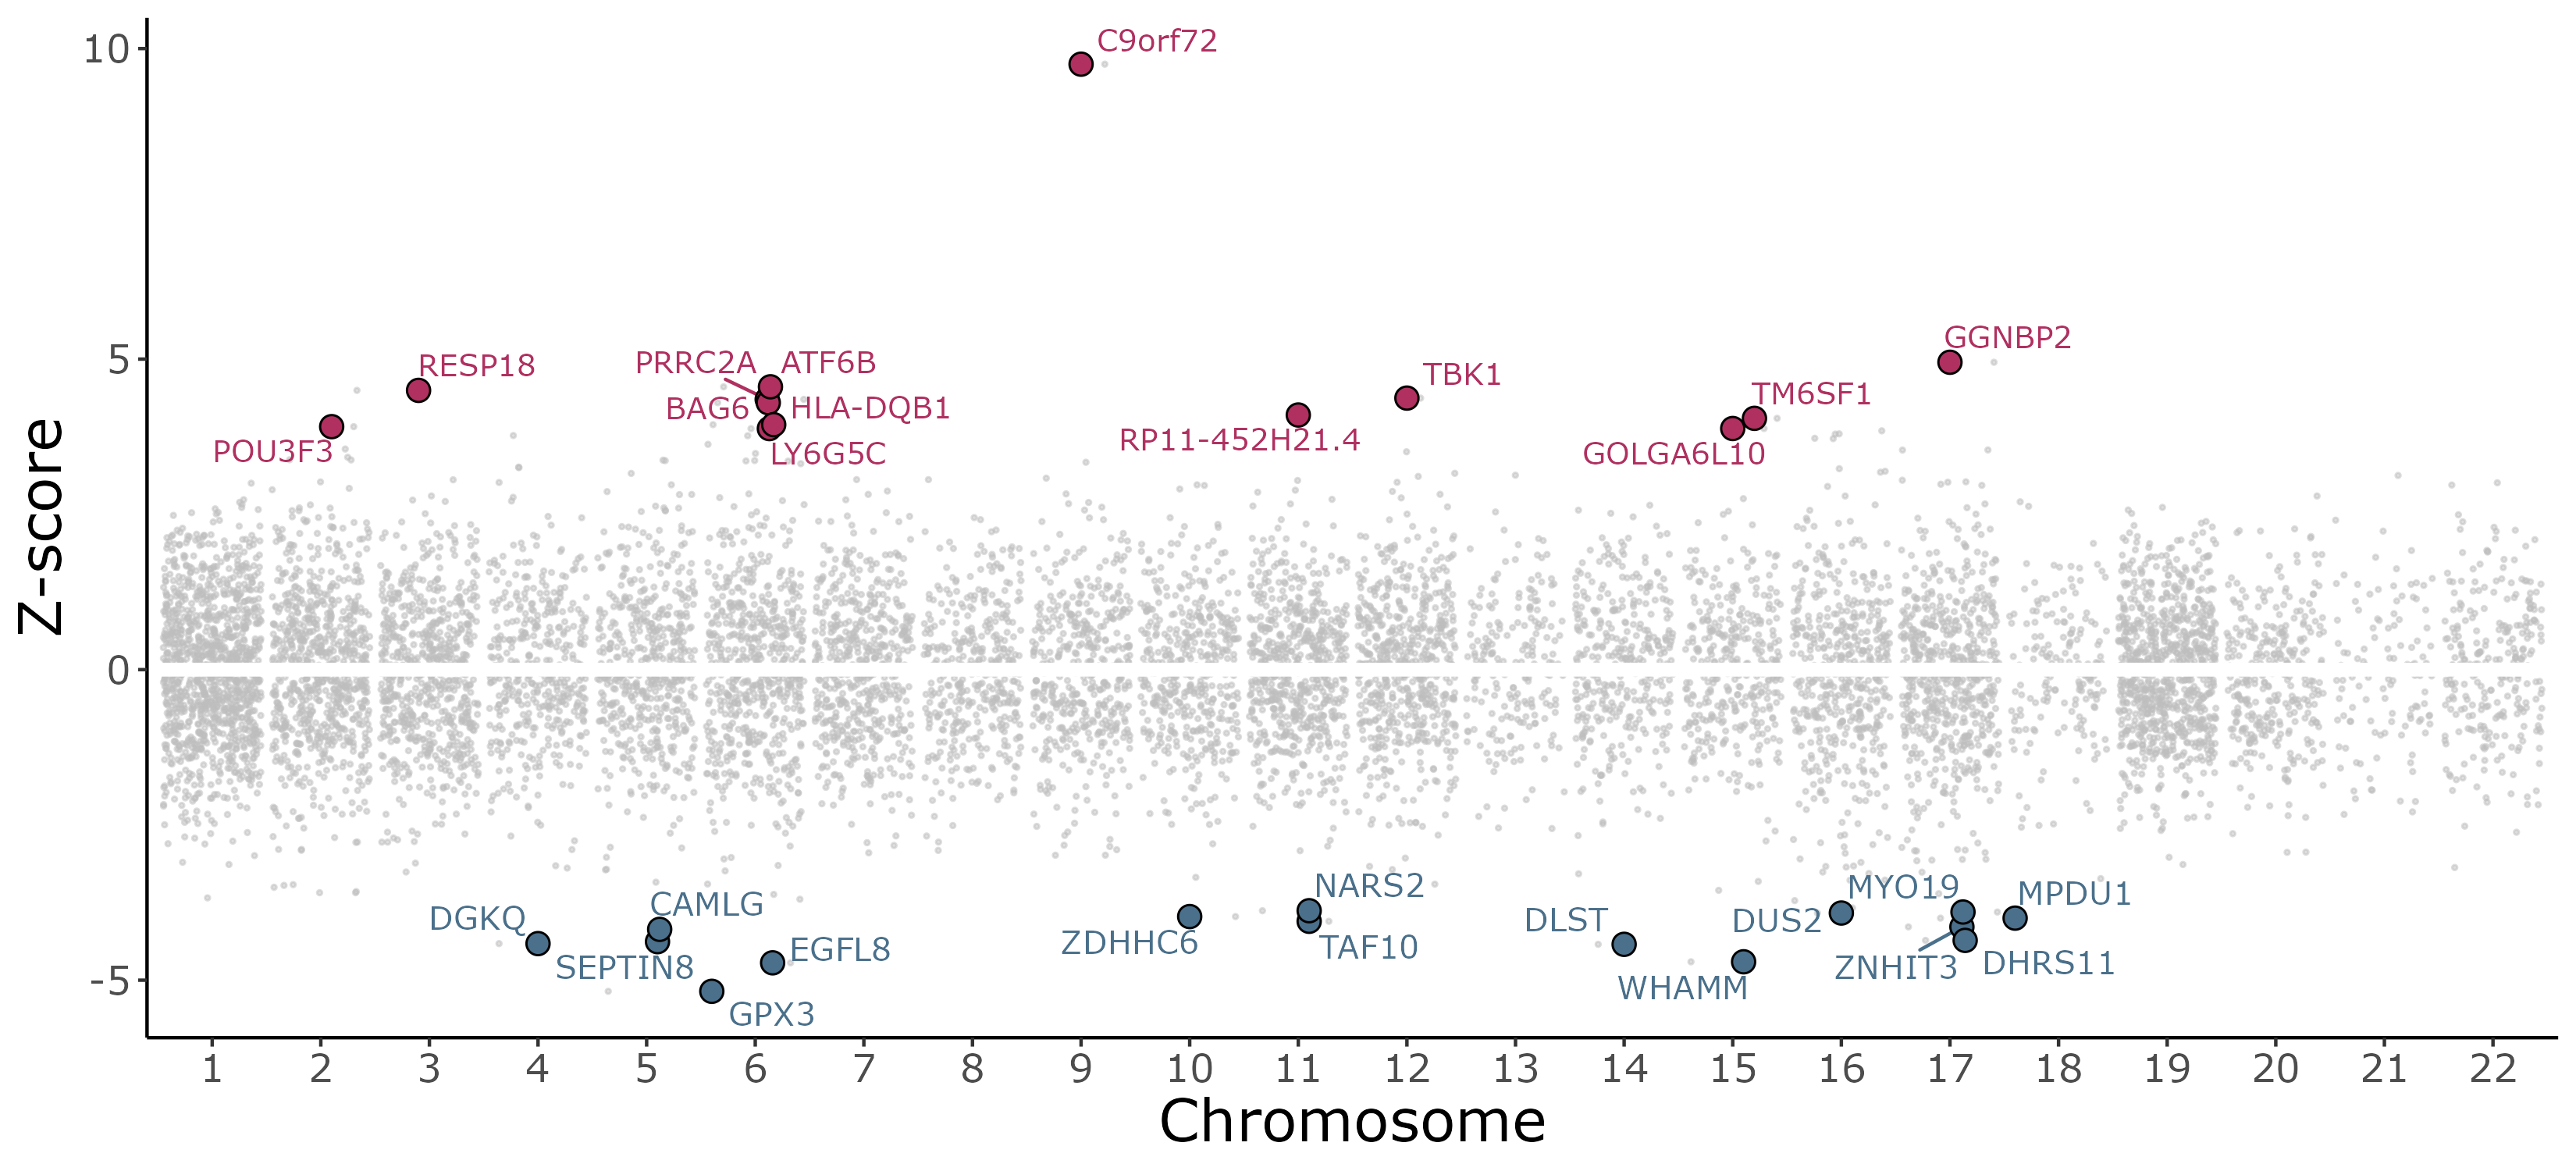

In [108]:
from IPython.display import Image
Image(filename='/data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/trial.SpinalCord.c1.VR.ALS.onlyFDR.nocolor.png')


In [17]:
%%bash
cd /data/ALS_50k/SaraSaez_ALS/2022_01_06.ALS.DrugsRepositioning
module load R/4.1.0
R --vanilla --no-save
# Load libraries
library(data.table)
library(tidyverse)
library(ggplot2)
library(dplyr)
library(RColorBrewer)
library(limma)
library(edgeR)
library('org.Hs.eg.db')
# unzip the Cervical Spinal Cord

######

data <- fread("pan.ALS.txt")
head(data)
data <- dplyr::select(data, geneid = gene_id,  log2FoldChange, padj)

data <- filter(data, padj < 0.05)
data$direction[data$log2FoldChange > 0] = "up"
data$direction[data$log2FoldChange < 0] = "down"

 
data$ENS <- data$geneid
head(data)
symbols <- as.character(data$ENS)
head(symbols)
con <- mapIds(org.Hs.eg.db, symbols, 'ENTREZID', 'ENSEMBL')
con <- as.data.frame(con)
head(con)
ens <- dplyr::select(data, ENS)
binded <- cbind(ens,con)
head(binded)

write.table(binded, "pan.als.conversion.txt", row.names =T, col.names = F, sep=" ", quote = F)
data2 <- read.table("pan.als.conversion.txt", header = F)
head(data2)
colnames <- c("V1","ENS","geneID")
names(data2)<- colnames
head(data2)
data2$ENS <- as.character(data2$ENS)
data$ENS <- as.character(data$ENS)
merged = merge(data, data2, by = "ENS", all = F)

print <- merged


topUP = filter(print, direction == "up")
upset = as.character(topUP$geneID)

topDN = filter(print, direction == "down")
downset = as.character(topDN$geneID)
head(topUP)
head(downset)


# Load drug perturbation libraries

library(mygene)
library(Hmisc)
library(signatureSearch)
library(ExperimentHub); library(rhdf5)
eh <- ExperimentHub()
lincs <- eh[["EH3226"]]; lincs_expr <- eh[["EH3227"]]
h5ls(lincs)



#LINCS method using the same pertub. database and UP/DN regulated genes
qsig_lincs <- qSig(query = list(upset=upset, downset=downset), 
                   gess_method="LINCS", refdb=lincs)
lincsm <- gess_lincs(qsig_lincs, sortby="NCS", tau=TRUE, workers=1)
result(lincsm)
df_lincs  = as.data.frame(lincsm@result)
write.csv(df_lincs, "panALS.ipsc.mediarxiv.ALS.lincsmethod.lincsDS.csv")

[+] Loading gcc  9.2.0  ... 
[+] Loading GSL 2.6 for GCC 9.2.0 ...
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading openmpi 4.0.5  for GCC 9.2.0 
[+] Loading ImageMagick  7.0.8  on cn4277 
[+] Loading HDF5  1.10.4 
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading NetCDF 4.7.4_gcc9.2.0 
[+] Loading pandoc  2.17.1.1  on cn4277 
[+] Loading pcre2 10.21  ... 
[+] Loading R 4.1.0 



R version 4.1.0 (2021-05-18) -- "Camp Pontanezen"
Copyright (C) 2021 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> # Load libraries
> library(data.table)
> library(tidyverse)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()


> library(ggplot2)
> library(dplyr)
> library(RColorBrewer)
> library(limma)
> library(edgeR)
> library('org.Hs.eg.db')


Loading required package: AnnotationDbi
Loading required package: stats4
Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following object is masked from ‘package:limma’:

    plotMA

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min

Loading required package: Biobase
Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconduc

> # unzip the Cervical Spinal Cord
> 
> ######
> 
> data <- fread("pan.ALS.txt")
> head(data)
   gene_name         gene_id   baseMean log2FoldChange     lfcSE      stat
1:      TBX5 ENSG00000089225   3.673370      -3.103291 0.6499186 -4.774891
2:    POU5F1 ENSG00000204531  62.072376      -1.865762 0.4158933 -4.486155
3:  MTCO1P12 ENSG00000237973 572.701897      -1.601035 0.1962405 -8.158533
4:    CROCC2 ENSG00000226321   8.794508      -1.558207 0.3704684 -4.206046
5:  MTCO2P12 ENSG00000229344   7.853073      -1.445177 0.3127088 -4.621477
6:    AACSP1 ENSG00000250420  62.083860      -1.009958 0.2490903 -4.054587
     pvalue         padj
1: 1.80e-06 7.708391e-03
2: 7.25e-06 1.165352e-02
3: 3.39e-16 9.260000e-12
4: 2.60e-05 2.535473e-02
5: 3.81e-06 9.245737e-03
6: 5.02e-05 3.713760e-02
> data <- dplyr::select(data, geneid = gene_id,  log2FoldChange, padj)
> 
> data <- filter(data, padj < 0.05)
> data$direction[data$log2FoldChange > 0] = "up"
> data$direction[data$log2FoldChange < 0] = "do

'select()' returned 1:1 mapping between keys and columns


> con <- as.data.frame(con)
> head(con)
                      con
ENSG00000089225      6910
ENSG00000204531      5460
ENSG00000237973 107075141
ENSG00000226321    728763
ENSG00000229344 107075310
ENSG00000250420    729522
> ens <- dplyr::select(data, ENS)
> binded <- cbind(ens,con)
> head(binded)
               ENS       con
1: ENSG00000089225      6910
2: ENSG00000204531      5460
3: ENSG00000237973 107075141
4: ENSG00000226321    728763
5: ENSG00000229344 107075310
6: ENSG00000250420    729522
> 
> write.table(binded, "pan.als.conversion.txt", row.names =T, col.names = F, sep=" ", quote = F)
> data2 <- read.table("pan.als.conversion.txt", header = F)
> head(data2)
  V1              V2        V3
1  1 ENSG00000089225      6910
2  2 ENSG00000204531      5460
3  3 ENSG00000237973 107075141
4  4 ENSG00000226321    728763
5  5 ENSG00000229344 107075310
6  6 ENSG00000250420    729522
> colnames <- c("V1","ENS","geneID")
> names(data2)<- colnames
> head(data2)
  V1             ENS    geneID


Loading required package: GenomicFeatures
Loading required package: GenomeInfoDb
Loading required package: GenomicRanges


> library(Hmisc)


Loading required package: lattice
Loading required package: survival
Loading required package: Formula

Attaching package: ‘Hmisc’

The following object is masked from ‘package:AnnotationDbi’:

    contents

The following object is masked from ‘package:Biobase’:

    contents

The following objects are masked from ‘package:dplyr’:

    src, summarize

The following objects are masked from ‘package:base’:

    format.pval, units



> library(signatureSearch)


Loading required package: Rcpp
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘matrixStats’

The following objects are masked from ‘package:Biobase’:

    anyMissing, rowMedians

The following object is masked from ‘package:dplyr’:

    count


Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCum

> library(ExperimentHub); library(rhdf5)


Loading required package: AnnotationHub
Loading required package: BiocFileCache
Loading required package: dbplyr

Attaching package: ‘dbplyr’

The following objects are masked from ‘package:dplyr’:

    ident, sql


Attaching package: ‘AnnotationHub’

The following object is masked from ‘package:mygene’:

    query

The following object is masked from ‘package:Biobase’:

    cache



> eh <- ExperimentHub()


snapshotDate(): 2021-10-19


> lincs <- eh[["EH3226"]]; lincs_expr <- eh[["EH3227"]]


see ?signatureSearchData and browseVignettes('signatureSearchData') for documentation
loading from cache
see ?signatureSearchData and browseVignettes('signatureSearchData') for documentation
loading from cache


> h5ls(lincs)
  group     name       otype dclass           dim
0     /    assay H5I_DATASET  FLOAT 12328 x 45956
1     / colnames H5I_DATASET STRING     45956 x 1
2     / rownames H5I_DATASET STRING     12328 x 1
> 
> 
> 
> #LINCS method using the same pertub. database and UP/DN regulated genes
> qsig_lincs <- qSig(query = list(upset=upset, downset=downset), 
+                    gess_method="LINCS", refdb=lincs)


8 / 20 genes in up set share identifiers with reference database
9 / 23 genes in down set share identifiers with reference database


> lincsm <- gess_lincs(qsig_lincs, sortby="NCS", tau=TRUE, workers=1)
> result(lincsm)
# A tibble: 45,956 × 15
   pert       PCID  cell  type  trend   WTCS WTCS_…¹ WTCS_…²   NCS   Tau TauRe…³
   <chr>      <chr> <chr> <chr> <chr>  <dbl>   <dbl>   <dbl> <dbl> <dbl>   <int>
 1 BRD-K4219… 4448… A549  trt_… up     0.838 7.05e-6 7.48e-5  1.91  99.9    4920
 2 BRD-K9797… 4448… A549  trt_… up     0.783 9.44e-6 7.48e-5  1.78  99.4    4920
 3 etacrynic… 3278  MCF7  trt_… up     0.791 9.10e-6 7.48e-5  1.77  97.4    6231
 4 teniposide 5396  SKB   trt_… up     0.757 1.06e-5 7.48e-5  1.76  99.4    2338
 5 BRD-K6989… 5465… NEU   trt_… up     0.727 1.19e-5 7.48e-5  1.76  99.7    2475
 6 danusertib 1144… A549  trt_… up     0.770 1.00e-5 7.48e-5  1.75  98.2    4920
 7 BRD-K6068… 2375… NEU   trt_… down  -0.713 1.25e-5 7.48e-5 -1.75 -99.8    2475
 8 adapalene  60164 NPC   trt_… up     0.738 1.14e-5 7.48e-5  1.75  99.9    3328
 9 pifithrin… 3276… A375  trt_… up     0.790 9.14e-6 7.48e-5  1.74  98.8    196

In [1]:
!pwd


/data/ALS_50k/SaraSaez_ALS/2022_01_06.ALS.DrugsRepositioning


In [14]:
%%bash
ls *ipsc.*.lincsDS.csv
scp c9.ipsc.lf0.5.ALS.lincsmethod.lincsDS.csv c9.ipsc.lfc0.5.ALS.lincsmethod.lincsDS.csv
echo "c9.ipsc.lfc0.5.ALS.lincsmethod.lincsDS.csv
fus.ipsc.lfc0.5.ALS.lincsmethod.lincsDS.csv
tardbp.ipsc.lfc0.5.ALS.lincsmethod.lincsDS.csv" > list.of.IPSC.csv

APPROVED.DFMEANS.tardbp.ipsc.lfc0.5.ALS.lincsmethod.lincsDS.csv
c9.ipsc.lf0.5.ALS.lincsmethod.lincsDS.csv
c9.ipsc.mediarxiv.ALS.lincsmethod.lincsDS.csv
fus.ipsc.lfc0.5.ALS.lincsmethod.lincsDS.csv
fus.ipsc.mediarxiv.ALS.lincsmethod.lincsDS.csv
panALS.ipsc.mediarxiv.ALS.lincsmethod.lincsDS.csv
tardbp.ipsc.lfc0.5.ALS.lincsmethod.lincsDS.csv
tardbp.ipsc.mediarxiv.ALS.lincsmethod.lincsDS.csv


# Additional analisis (optional)

In [ ]:
from IPython.display import Image
Image(filename='/data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/smetaxcan/VR2021.ALS/CmapConcordance.VR.ALS.cmapmethod.lincsDS.BrainMetaxcanFDR.png', width = 900, height = 600)

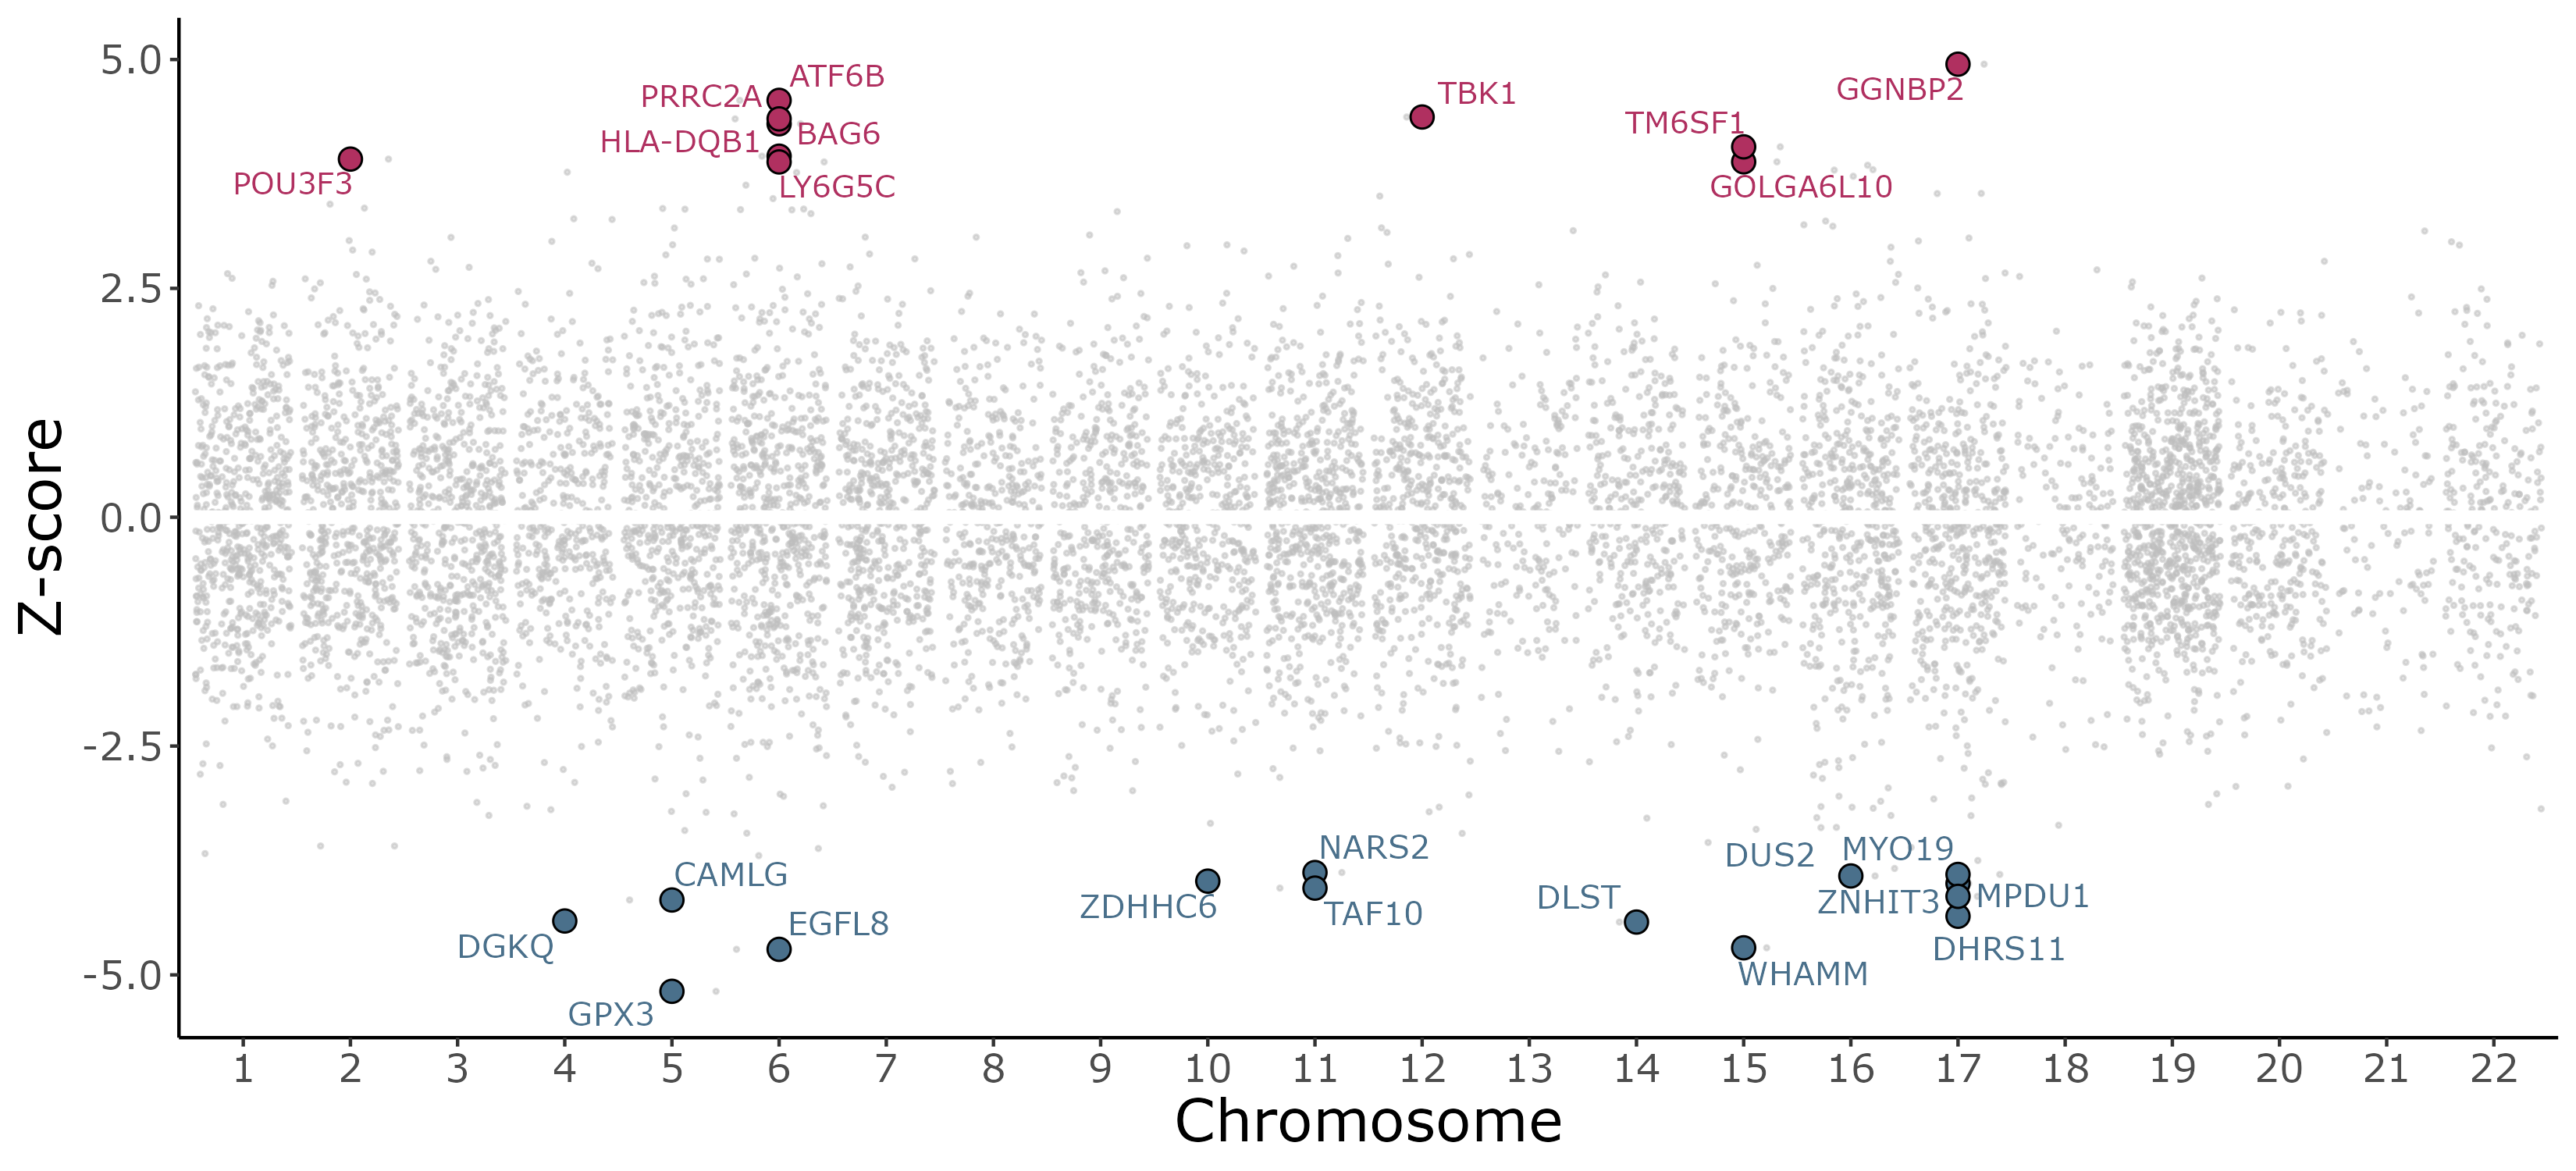

In [8]:
from IPython.display import Image
Image(filename='/data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/SpinalCord.c1.VR.ALS.onlyFDR.nocolor.png', width = 1000, height = 800)

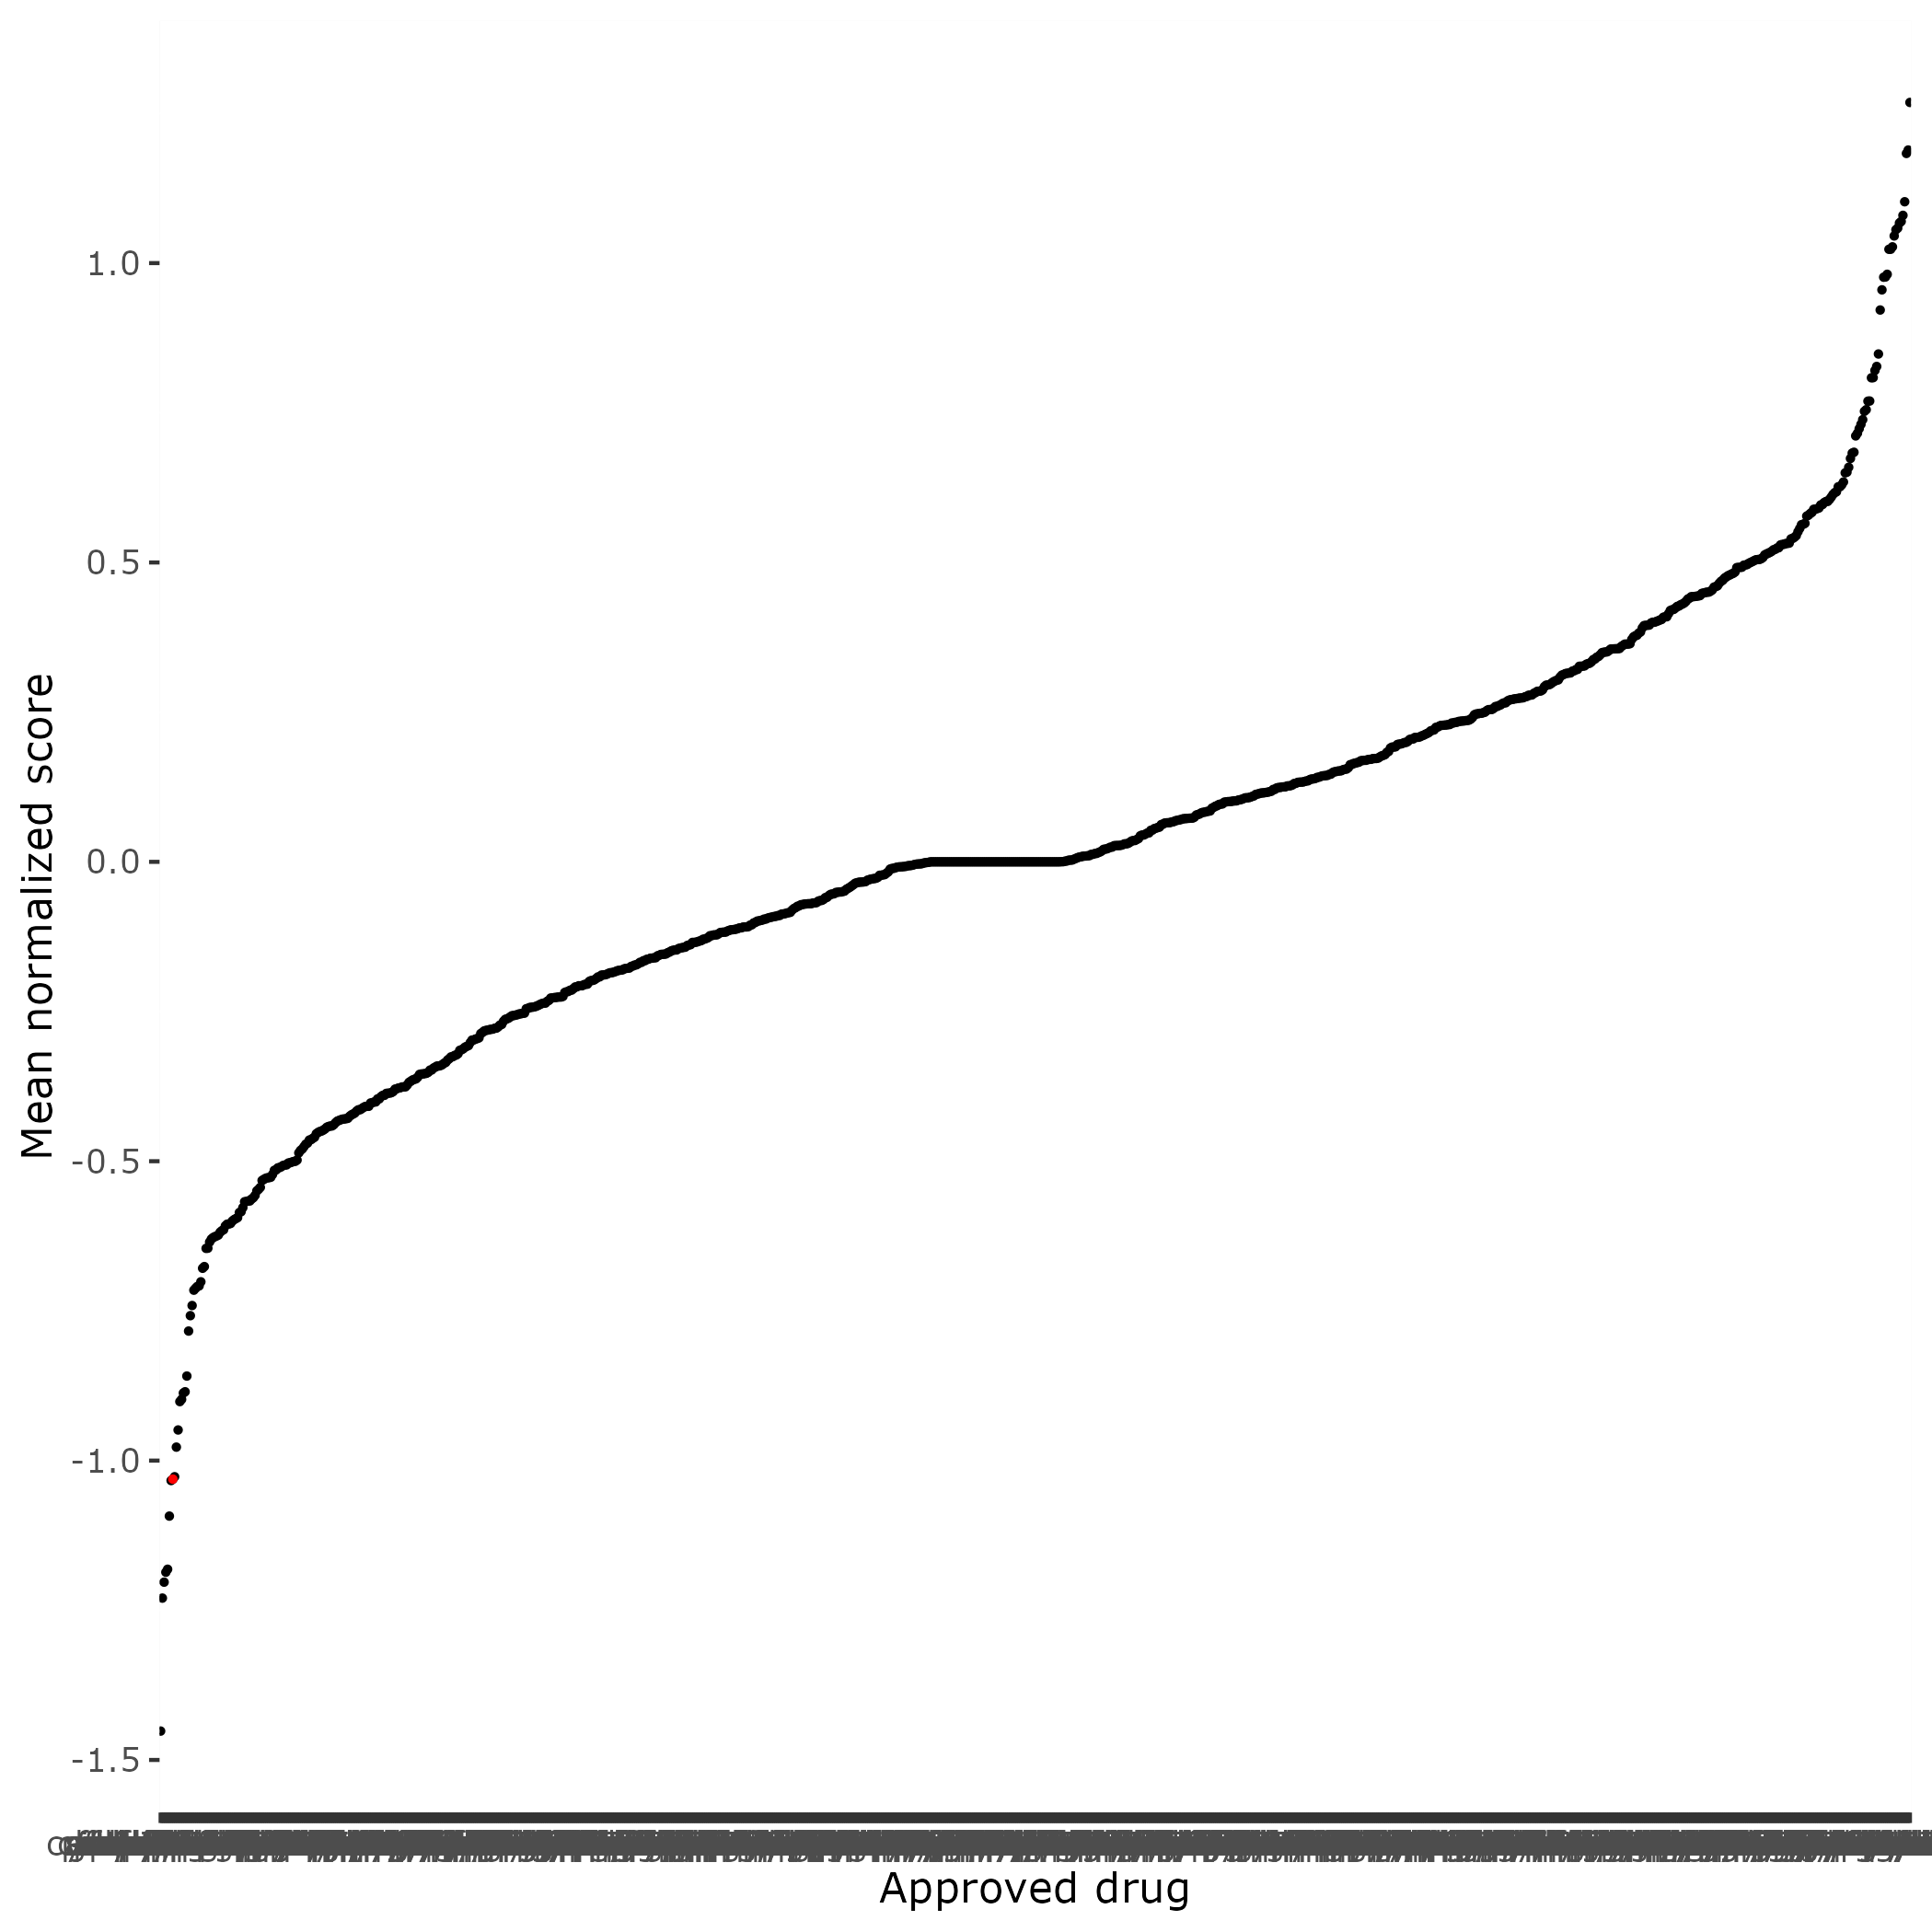

In [1]:
from IPython.display import display
from PIL import Image

plot="/data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/All.Drugs2.png"
display(Image.open(plot))



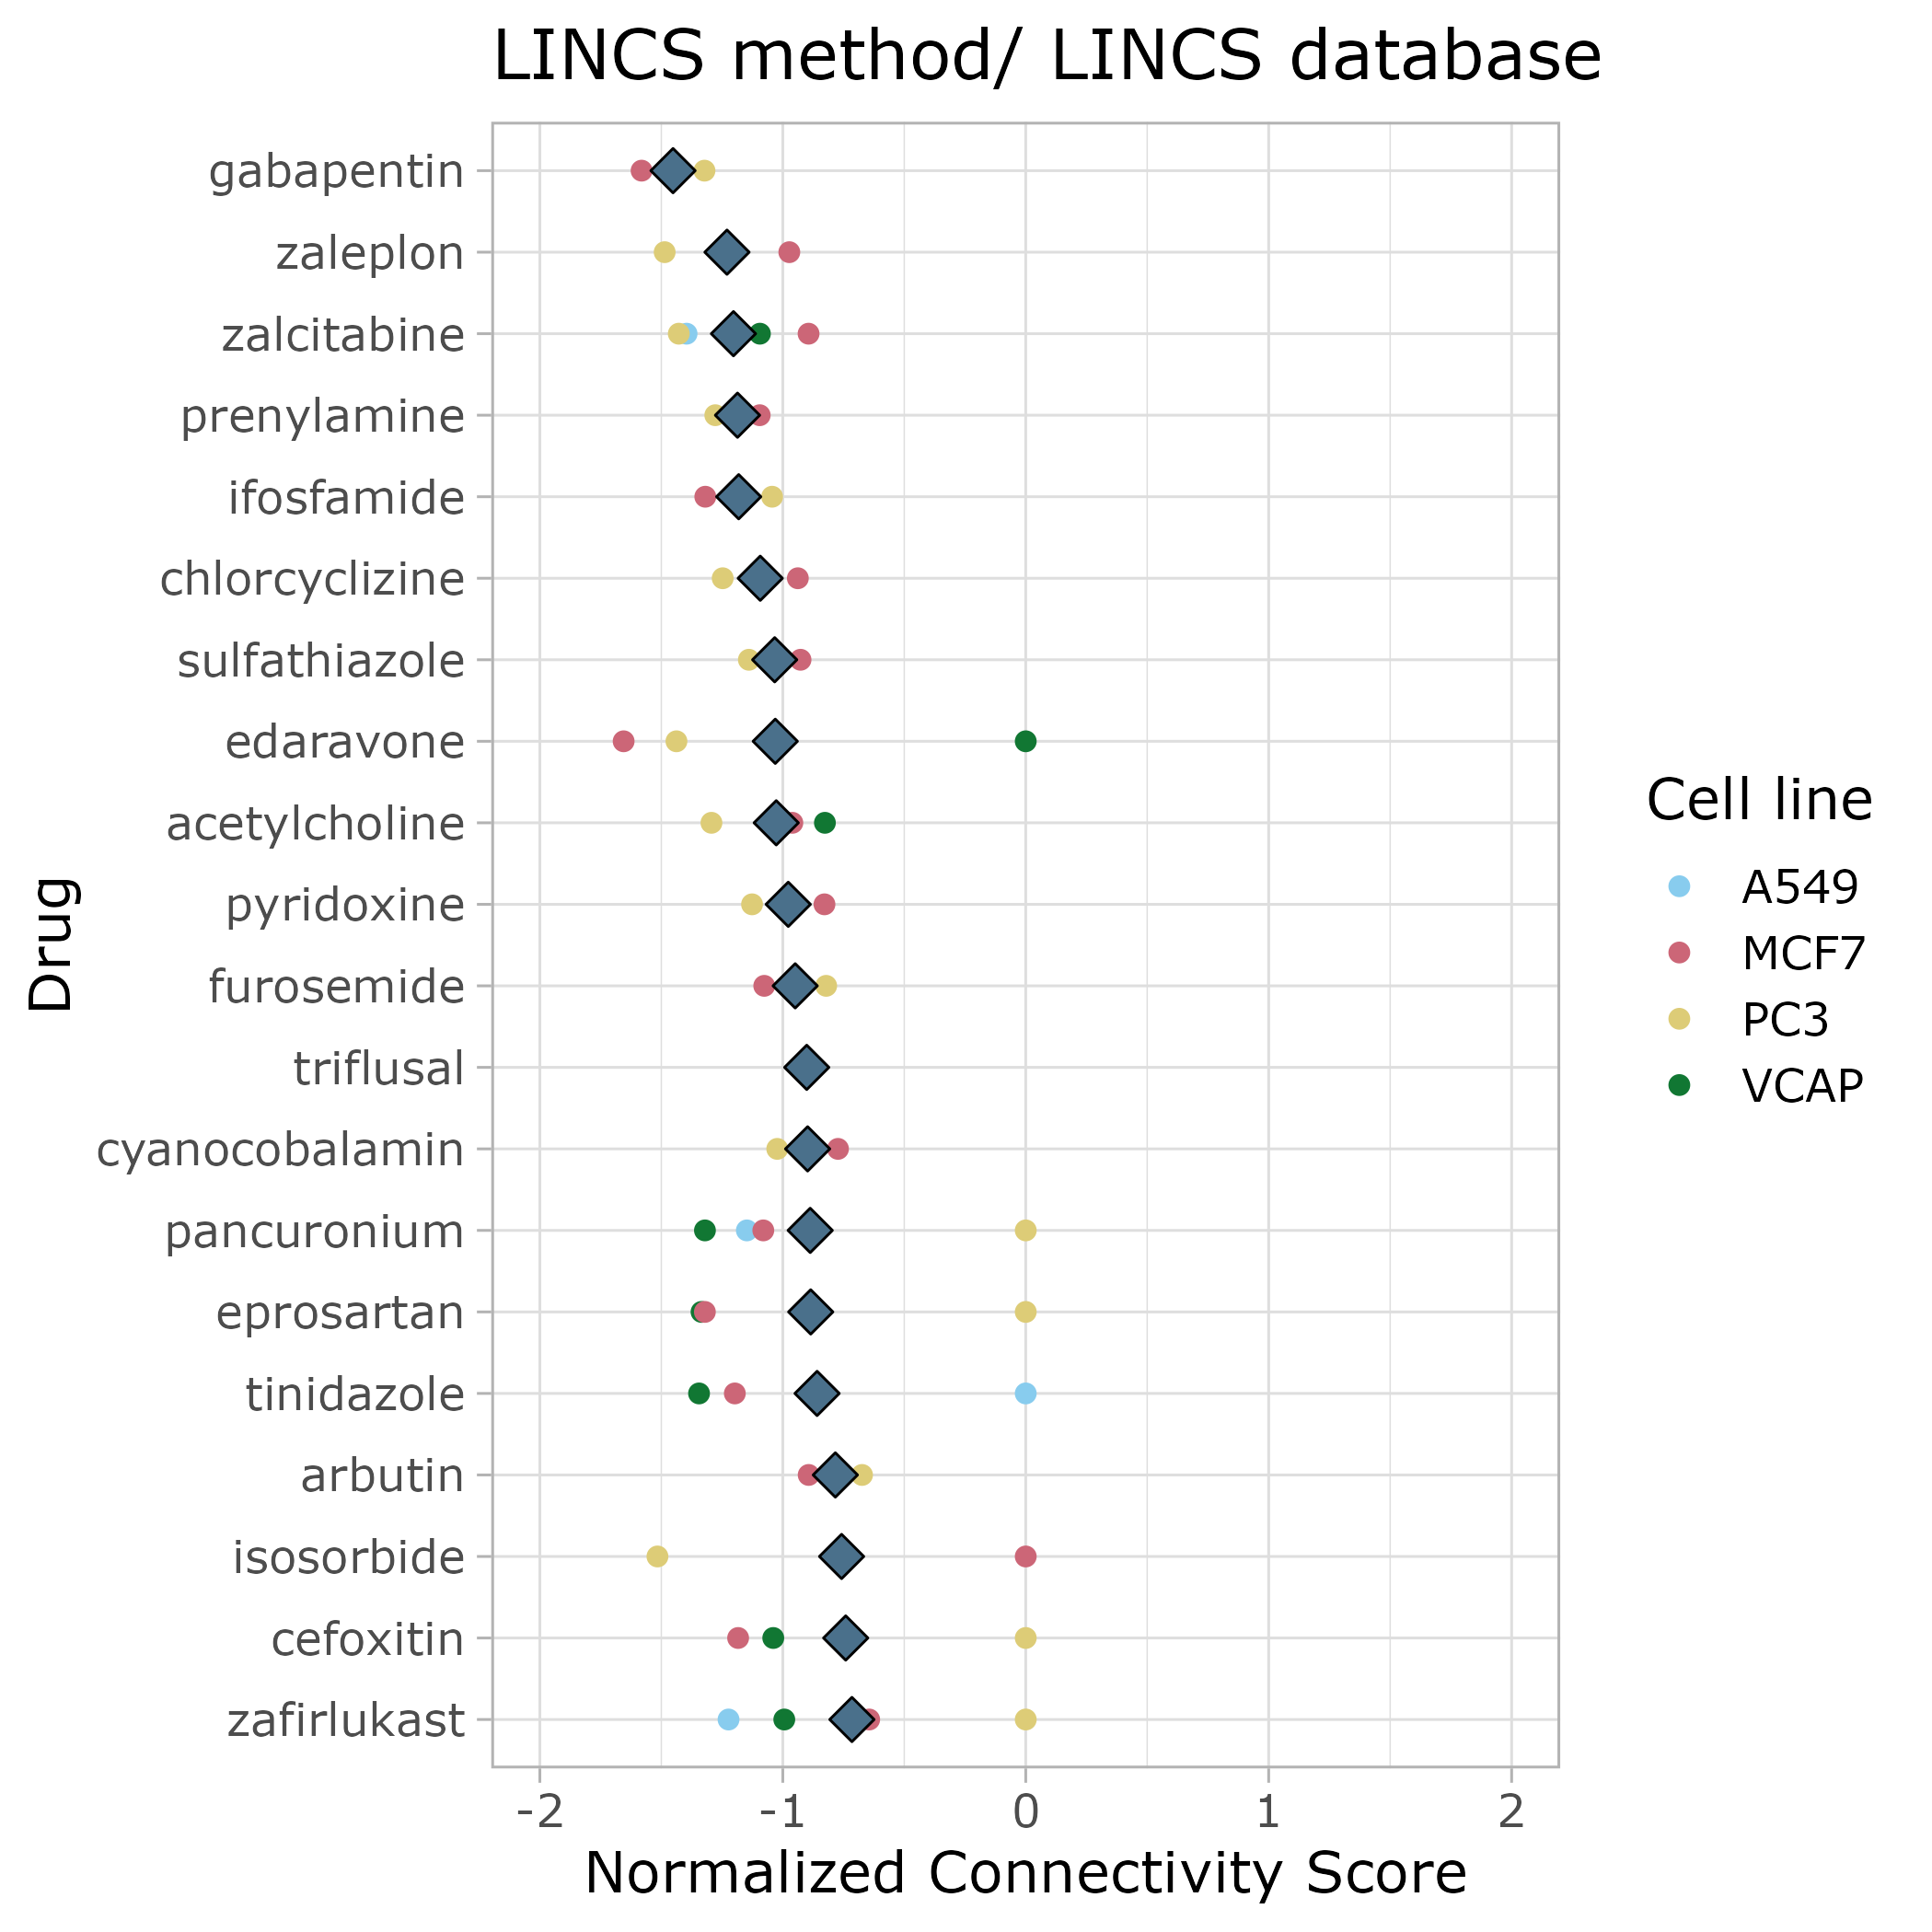

In [22]:

from IPython.display import Image
Image(filename='/data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/DrugBank.approved.VR.ALS.lincsmethod.lincsDB.SpinalCordc1FDR.png', width = 1000, height = 800)


In [4]:
%%bash
cd /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/

module load R/4.1.0
R --vanilla --no-save
library(data.table)
library(tidyverse)
library(ggplot2)
library(dplyr)
library(RColorBrewer)


  
lincs <- fread("/data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.lincsmethod.lincsDS.SpinalCordc1FDR.csv", header = T)
head(lincs)
lincs <- lincs %>% filter(!grepl('^[A-Z]+', pert))
#lincs <- lincs %>% filter(!grepl('BRD', pert))
#lincs <- lincs %>% filter(!grepl('GBR-', pert))
#lincs <- lincs %>% filter(!grepl('PSH-', pert))
#lincs <- lincs %>% filter(!grepl('SA-', pert))
#lincs <- lincs %>% filter(!grepl('S-', pert))
#lincs <- lincs %>% filter(!grepl('^[A-Z]+', pert))


df_means <- lincs %>% group_by(pert) %>% summarise(NCS=mean(NCS))
head(df_means)
data <- as.data.frame(df_means)
write.table(data, "VR.ALS.lincsmethod.lincsDB.SpinalCordc1FDR.df.means.tab", quote = F,sep = "\t", row.names = F)

qwrqkefhwqyhfqdyget

lincs <- lincs[!grepl('[A-Z]', lincs$pert)]
lincs <- lincs %>% filter(!grepl('benzo(e)pyrene', pert))
lincs <- lincs %>% filter(!grepl('1,2-propylene-glycol', pert))
lincs <- lincs %>% filter(!grepl('syringic-acid', pert))
lincs <- lincs %>% filter(!grepl('oleanolic-acid', pert))
lincs <- lincs %>% filter(!grepl('apramycin', pert))
lincs <- lincs %>% filter(!grepl('9128', PCID))
lincs <- lincs %>% filter(!grepl('vitexin', pert))
lincs <- lincs %>% filter(!grepl('isoliquiritigenin', pert))





#lincs <- lincs %>% filter(!grepl('BRD', pert))
#lincs <- lincs %>% filter(!grepl('GBR-', pert))
#lincs <- lincs %>% filter(!grepl('PSH-', pert))
#lincs <- lincs %>% filter(!grepl('SA-', pert))
#lincs <- lincs %>% filter(!grepl('S-', pert))
#lincs <- lincs %>% filter(!grepl('TUL-', pert))


head(lincs)
top20 <- lincs[order(NCSct),] 
head(top20)

unique <- distinct(top20, pert, .keep_all = TRUE)
head(unique)
top20unique <- unique %>% slice(1:20)
top20unique <- select(top20unique, pert)
merged2 <- merge(top20unique, lincs, by = "pert")
print(merged2)

data <- merged2

p <- ggplot(data, aes(pert, NCS))
p + geom_point(aes(colour = cell))

cbp1  <- c("#88CCEE", "#CC6677", "#DDCC77", "#117733",
"#332288", "#AA4499", "#999933","#44AA99", 
"#6699CC", "#C476A9","#E9C766","#74C476",
"#27698D","#AF87B9","#D9D6AB" ,"#B3D69C",
"#60ABD4", "#E573E5","#74C476","#888888", "#C476A9", "#AE017E", "#E5F5F9",
"#FFF7FB", "#74C476","#CB181D" )


p + scale_color_manual(values = cbp1)

df_means <- data %>% group_by(pert) %>% summarise(NCS=mean(NCS))
head(df_means)
head(data)

ggplot(data = data) +
  aes((x=reorder(pert,-NCS)), y = NCS) +
  geom_point(aes(colour = cell),  size = 2) + 
  geom_point(data=df_means, 
             col="black",  
             size = 4,
             shape = 23,
             fill = "skyblue4") + scale_color_manual(values = cbp1) + coord_flip() +
  labs(x = "Drug",
    y = "Normalized Connectivity Score",
    colour = "Cell line"
  ) +
  theme_light(15)+ ggtitle("LINCS method/ LINCS database")
  
ggsave("VR.ALS.lincsmethod.lincsDB.SpinalCordc1FDR.png",
  plot = last_plot(),
  device = NULL,
  path = NULL,
  scale = 1,
  dpi = 300)
  
    
cmaplincs <- fread("VR.ALS.cmapmethod.lincsDS.BrainMetaxcanFDR.csv", header = T)
head(cmaplincs)


data <- fread("VR.ALS.cmapmethod.cmapDS.BrainMetaxcanFDR.csv", header = T)
head(data)
df_means <- data %>% group_by(pert) %>% summarise(raw_score.ct=mean(raw_score))
df_means <- select(df_means, pert, raw_score.ct)
percell <- data %>% group_by(pert) %>% summarise(number=n())
head(percell)
percell <- filter(percell, number > 2)
data2 <- merge(data, percell, by = "pert")
data2 <- merge(data2, df_means, by = "pert")

unique <- distinct(data2, pert, .keep_all = TRUE)
head(unique)

top20 <- unique[order(raw_score.ct),] 
head(top20)
top20 <- top20 %>% slice(1:20)
top20 <- select(top20, pert)
top20 <- merge(top20, data2, by = "pert")
head(top20)

top20 <- select(top20, pert)
head(top20)
merged2 <- merge(cmaplincs, top20, by = "pert")
head(merged2)

data <- merged2


p <- ggplot(data, aes(pert, raw_score))
p + geom_point(aes(colour = cell))

library(RColorBrewer)
cbp1  <- c("#88CCEE", "#CC6677", "#DDCC77", "#117733",
"#332288", "#AA4499", "#999933","#44AA99", 
"#6699CC", "#C476A9","#E9C766","#74C476",
"#27698D","#AF87B9","#D9D6AB" ,"#B3D69C",
"#60ABD4", "#E573E5","#74C476","#888888", "#C476A9", "#AE017E", "#E5F5F9",
"#FFF7FB", "#74C476","#CB181D" )


p + scale_color_manual(values = cbp1)
display.brewer.all()
df_means <- data %>% group_by(pert) %>% summarise(raw_score=mean(raw_score))
ggplot(data = data) +
  aes((x=reorder(pert,-raw_score)), y = raw_score) +
  geom_point(aes(colour = cell),  size = 2) + 
  geom_point(data=df_means, 
             col="black",  
             size = 4,
             shape = 23,
             fill = "#36a653") + scale_color_manual(values = cbp1) + coord_flip() +
  labs(x = "Drug",
    y = "Connectivity score",
    colour = "Cell line"
  ) +
  theme_light(15) + ggtitle("CMAP method/ LINCS database")
  
  
ggsave("CmapConcordance.VR.ALS.cmapmethod.lincsDS.BrainMetaxcanFDR.png",
  plot = last_plot(),
  device = NULL,
  path = NULL,
  scale = 1,
  dpi = 300)

[+] Loading gcc  9.2.0  ... 
[+] Loading GSL 2.6 for GCC 9.2.0 ...
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading openmpi 4.0.5  for GCC 9.2.0 
[+] Loading ImageMagick  7.0.8  on cn2461 
[+] Loading HDF5  1.10.4 
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading NetCDF 4.7.4_gcc9.2.0 
[+] Loading pandoc  2.17.1.1  on cn2461 
[+] Loading pcre2 10.21  ... 
[+] Loading R 4.1.0 



R version 4.1.0 (2021-05-18) -- "Camp Pontanezen"
Copyright (C) 2021 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> library(data.table)
> library(tidyverse)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──
✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()


> library(ggplot2)
> library(dplyr)
> library(RColorBrewer)
> 
> 
>   
> lincs <- fread("VR.ALS.lincsmethod.lincsDS.SpinalCordc1FDR.csv", header = T)
> head(lincs)
   V1          pert     PCID    cell   type trend       WTCS    WTCS_Pval
1:  1 BRD-K69795440 44246520    VCAP trt_cp  down -0.7096592 1.262036e-05
2:  2    sildenafil     5212     ASC trt_cp    up  0.6980398 1.314258e-05
3:  3     PD-160170  9820766     ASC trt_cp  down -0.6471565 1.536202e-05
4:  4 BRD-A82323890 15115512 FIBRNPC trt_cp    up  0.6807512 1.388239e-05
5:  5 BRD-K45156967 44620852     PC3 trt_cp    up  0.6733886 1.423054e-05
6:  6          DMBI  5353593    HA1E trt_cp    up  0.6694761 1.440461e-05
       WTCS_FDR       NCS       Tau TauRefSize     NCSct N_upset N_downset
1: 9.084427e-05 -1.814553 -99.96735       6126 0.9576124       9        13
2: 9.084427e-05  1.796871  99.87207       2345 0.0000000       9        13
3: 9.084427e-05 -1.790330 -99.95736       2345 0.8182774       9        13
4: 9.084427e-05  1

Error: object 'qwrqkefhwqyhfqdyget' not found
Execution halted
bash: line 27: unexpected EOF while looking for matching `"'
bash: line 33: syntax error: unexpected end of file


CalledProcessError: Command 'b'cd /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/\n\nmodule load R/4.1.0\nR --vanilla --no-save\nlibrary(data.table)\nlibrary(tidyverse)\nlibrary(ggplot2)\nlibrary(dplyr)\nlibrary(RColorBrewer)\n\n\n  \nlincs <- fread("VR.ALS.lincsmethod.lincsDS.SpinalCordc1FDR.csv", header = T)\nhead(lincs)\nlincs <- lincs %>% filter(!grepl(\'^[A-Z]+\', pert))\nlincs <- lincs %>% filter(!grepl(\'BRD\', pert))\nlincs <- lincs %>% filter(!grepl(\'GBR-\', pert))\nlincs <- lincs %>% filter(!grepl(\'PSH-\', pert))\nlincs <- lincs %>% filter(!grepl(\'SA-\', pert))\nlincs <- lincs %>% filter(!grepl(\'S-\', pert))\nlincs <- lincs %>% filter(!grepl(\'^[A-Z]+\', pert))\n\n\ndf_means <- lincs %>% group_by(pert) %>% summarise(NCS=mean(NCS))\nhead(df_means)\ndata <- as.data.frame(df_means)\nwrite.table(data, "VR.ALS.lincsmethod.lincsDB.SpinalCordc1FDR.df.means.tab", quote = F,sep = "\\t", row.names = F)\n\nqwrqkefhwqyhfqdyget\n\nlincs <- lincs[!grepl(\'[A-Z]\', lincs$pert)]\nlincs <- lincs %>% filter(!grepl(\'benzo(e)pyrene\', pert))\nlincs <- lincs %>% filter(!grepl(\'1,2-propylene-glycol\', pert))\nlincs <- lincs %>% filter(!grepl(\'syringic-acid\', pert))\nlincs <- lincs %>% filter(!grepl(\'oleanolic-acid\', pert))\nlincs <- lincs %>% filter(!grepl(\'apramycin\', pert))\nlincs <- lincs %>% filter(!grepl(\'9128\', PCID))\nlincs <- lincs %>% filter(!grepl(\'vitexin\', pert))\nlincs <- lincs %>% filter(!grepl(\'isoliquiritigenin\', pert))\n\n\n\n\n\n#lincs <- lincs %>% filter(!grepl(\'BRD\', pert))\n#lincs <- lincs %>% filter(!grepl(\'GBR-\', pert))\n#lincs <- lincs %>% filter(!grepl(\'PSH-\', pert))\n#lincs <- lincs %>% filter(!grepl(\'SA-\', pert))\n#lincs <- lincs %>% filter(!grepl(\'S-\', pert))\n#lincs <- lincs %>% filter(!grepl(\'TUL-\', pert))\n\n\nhead(lincs)\ntop20 <- lincs[order(NCSct),] \nhead(top20)\n\nunique <- distinct(top20, pert, .keep_all = TRUE)\nhead(unique)\ntop20unique <- unique %>% slice(1:20)\ntop20unique <- select(top20unique, pert)\nmerged2 <- merge(top20unique, lincs, by = "pert")\nprint(merged2)\n\ndata <- merged2\n\np <- ggplot(data, aes(pert, NCS))\np + geom_point(aes(colour = cell))\n\ncbp1  <- c("#88CCEE", "#CC6677", "#DDCC77", "#117733",\n"#332288", "#AA4499", "#999933","#44AA99", \n"#6699CC", "#C476A9","#E9C766","#74C476",\n"#27698D","#AF87B9","#D9D6AB" ,"#B3D69C",\n"#60ABD4", "#E573E5","#74C476","#888888", "#C476A9", "#AE017E", "#E5F5F9",\n"#FFF7FB", "#74C476","#CB181D" )\n\n\np + scale_color_manual(values = cbp1)\n\ndf_means <- data %>% group_by(pert) %>% summarise(NCS=mean(NCS))\nhead(df_means)\nhead(data)\n\nggplot(data = data) +\n  aes((x=reorder(pert,-NCS)), y = NCS) +\n  geom_point(aes(colour = cell),  size = 2) + \n  geom_point(data=df_means, \n             col="black",  \n             size = 4,\n             shape = 23,\n             fill = "skyblue4") + scale_color_manual(values = cbp1) + coord_flip() +\n  labs(x = "Drug",\n    y = "Normalized Connectivity Score",\n    colour = "Cell line"\n  ) +\n  theme_light(15)+ ggtitle("LINCS method/ LINCS database")\n  \nggsave("VR.ALS.lincsmethod.lincsDB.SpinalCordc1FDR.png",\n  plot = last_plot(),\n  device = NULL,\n  path = NULL,\n  scale = 1,\n  dpi = 300)\n  \n    \ncmaplincs <- fread("VR.ALS.cmapmethod.lincsDS.BrainMetaxcanFDR.csv", header = T)\nhead(cmaplincs)\n\n\ndata <- fread("VR.ALS.cmapmethod.cmapDS.BrainMetaxcanFDR.csv", header = T)\nhead(data)\ndf_means <- data %>% group_by(pert) %>% summarise(raw_score.ct=mean(raw_score))\ndf_means <- select(df_means, pert, raw_score.ct)\npercell <- data %>% group_by(pert) %>% summarise(number=n())\nhead(percell)\npercell <- filter(percell, number > 2)\ndata2 <- merge(data, percell, by = "pert")\ndata2 <- merge(data2, df_means, by = "pert")\n\nunique <- distinct(data2, pert, .keep_all = TRUE)\nhead(unique)\n\ntop20 <- unique[order(raw_score.ct),] \nhead(top20)\ntop20 <- top20 %>% slice(1:20)\ntop20 <- select(top20, pert)\ntop20 <- merge(top20, data2, by = "pert")\nhead(top20)\n\ntop20 <- select(top20, pert)\nhead(top20)\nmerged2 <- merge(cmaplincs, top20, by = "pert")\nhead(merged2)\n\ndata <- merged2\n\n\np <- ggplot(data, aes(pert, raw_score))\np + geom_point(aes(colour = cell))\n\nlibrary(RColorBrewer)\ncbp1  <- c("#88CCEE", "#CC6677", "#DDCC77", "#117733",\n"#332288", "#AA4499", "#999933","#44AA99", \n"#6699CC", "#C476A9","#E9C766","#74C476",\n"#27698D","#AF87B9","#D9D6AB" ,"#B3D69C",\n"#60ABD4", "#E573E5","#74C476","#888888", "#C476A9", "#AE017E", "#E5F5F9",\n"#FFF7FB", "#74C476","#CB181D" )\n\n\np + scale_color_manual(values = cbp1)\ndisplay.brewer.all()\ndf_means <- data %>% group_by(pert) %>% summarise(raw_score=mean(raw_score))\nggplot(data = data) +\n  aes((x=reorder(pert,-raw_score)), y = raw_score) +\n  geom_point(aes(colour = cell),  size = 2) + \n  geom_point(data=df_means, \n             col="black",  \n             size = 4,\n             shape = 23,\n             fill = "#36a653") + scale_color_manual(values = cbp1) + coord_flip() +\n  labs(x = "Drug",\n    y = "Connectivity score",\n    colour = "Cell line"\n  ) +\n  theme_light(15) + ggtitle("CMAP method/ LINCS database")\n  \n  \nggsave("CmapConcordance.VR.ALS.cmapmethod.lincsDS.BrainMetaxcanFDR.png",\n  plot = last_plot(),\n  device = NULL,\n  path = NULL,\n  scale = 1,\n  dpi = 300)\n'' returned non-zero exit status 2.

In [10]:
%%bash
# Overlapping between Jack RNA-seq in spinal cord and twas...trying to establish the overlapping genes to see how similar are.
# These two datasets represent different time points of disease and the overlapping is not guaranteed 

cd /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/
module load R/4.1.0
R --vanilla --no-save
# Load libraries
library(data.table)
library(tidyverse)
library(ggplot2)
library(dplyr)
library(RColorBrewer)
library('org.Hs.eg.db')

# Read in the S-predixcan results from van Rheene
data = fread("VR.ALS.quick.harmo_Brain_Spinal_cord_cervical_c-1.FDR.csv", header=T)
head(data)
data$genename <- data$gene_name
data <- filter(data, Padj.FDR < 0.05)

# Read in the RNA-seq data from Jack (supplementary 2 of https://www.medrxiv.org/content/10.1101/2021.08.31.21262682v1)
jack <- fread("/data/ALS_50k/SaraSaez_ALS/2022_01_06.ALS.DrugsRepositioning/Jack.S2.DEGs.txt", header = T)
head(jack)
# use only cervical spinal cord
raw.pvalue = jack$cervical.p
Padj.bon = p.adjust(raw.pvalue, method = "fdr")

print = cbind(jack, Padj.bon)
#write.csv(print, "jack.spinalcord.cervical.bon.csv")
print <- filter(print, Padj.bon < 0.05)
UP = filter(print, cervical.lfc > 0)
print(UP)
DN = filter(print, cervical.lfc < 0)
print(DN)


merged <- merge(data, print, by = "genename")
dim(merged)
head(merged)



data = fread("VR.ALS.quick.harmo_Brain_Spinal_cord_cervical_c-1.FDR.csv", header=T)
head(data)
data$genename <- data$gene_name
data <- filter(data, Padj.FDR < 0.05)

jack <- fread("/data/ALS_50k/SaraSaez_ALS/2022_01_06.ALS.DrugsRepositioning/Jack.S2.DEGs.txt", header = T)
head(jack)
merged <-merge(data, jack, by = "genename")
print(merged)
write.csv(merged, "overlapping.vanRH2021.spinalcord.jack.spinalcord.cervical.csv")

# For VR, 7 genes with a significant p-value are common between the two datasets. However, only four has the same direction.


# Read in Nicolas et al imputed transcriptome
nicolas <- fread("/data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/ALS/ALS.quick.harmo.YESfreq_PM_Brain_Spinal_cord_cervical_c-1.csv", header =T)
nicolas$genename <- nicolas$gene_name
Raw = nicolas$pvalue
Padj.FDR = p.adjust(Raw, method = "fdr")
print2 = cbind(nicolas, Padj.FDR)
head(print2)
print2 <- filter(print2, Padj.FDR < 0.05)
#write.csv(print, "jack.spinalcord.cervical.bon.csv")
merged2 <- merge(print, print2, by = "genename")
dim(merged2)
head(merged2)
#no commom genes after applying p-value thresholds


# Analyzing the drugs using now 
jack <- fread("/data/ALS_50k/SaraSaez_ALS/2022_01_06.ALS.DrugsRepositioning/Jack.S2.DEGs.txt", header = T)
head(jack)
# use only cervical spinal cord
raw.pvalue = jack$cervical.p
Padj.bon = p.adjust(raw.pvalue, method = "bon")
print = cbind(jack, Padj.bon)


data <- print 
data$ENS <- data$geneid
head(data)
symbols <- as.character(data$ENS)
head(symbols)
con <- mapIds(org.Hs.eg.db, symbols, 'ENTREZID', 'ENSEMBL')
con <- as.data.frame(con)
head(con)
ens <- dplyr::select(data, ENS)
binded <- cbind(ens,con)
head(binded)

write.table(binded, "jack.conversion2.txt", row.names =T, col.names = F, sep=" ", quote = F)
data2 <- read.table("jack.conversion2.txt", header = F)
head(data2)
colnames <- c("V1","ENS","geneID")
names(data2)<- colnames
head(data2)
data2$ENS <- as.character(data2$ENS)
data$ENS <- as.character(data$ENS)
merged = merge(data, data2, by = "ENS", all = F)

print <- merged
print <- filter(print, Padj.bon < 0.05)

topUP = filter(print, cervical.lfc > 0)
upset = as.character(topUP$geneID)

topDN = filter(print, cervical.lfc < 0)
downset = as.character(topDN$geneID)



# Load drug perturbation libraries

library(mygene)
library(Hmisc)
library(signatureSearch)
library(ExperimentHub); library(rhdf5)
eh <- ExperimentHub()
cmap <- eh[["EH3223"]]; cmap_expr <- eh[["EH3224"]]
lincs <- eh[["EH3226"]]; lincs_expr <- eh[["EH3227"]]
h5ls(lincs)



#LINCS method using the same pertub. database and UP/DN regulated genes
qsig_lincs <- qSig(query = list(upset=upset, downset=downset), 
                   gess_method="LINCS", refdb=lincs)
lincsm <- gess_lincs(qsig_lincs, sortby="NCS", tau=TRUE, workers=1)
result(lincsm)
df_lincs  = as.data.frame(lincsm@result)
write.csv(df_lincs, "jack.spinalcord.cervical.bon.ALS.lincsmethod.lincsDS.csv")





[+] Loading gcc  9.2.0  ... 
[+] Loading GSL 2.6 for GCC 9.2.0 ...
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading openmpi 4.0.5  for GCC 9.2.0 
[+] Loading ImageMagick  7.0.8  on cn0856 
[+] Loading HDF5  1.10.4 
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading NetCDF 4.7.4_gcc9.2.0 
[+] Loading pandoc  2.17.1.1  on cn0856 
[+] Loading pcre2 10.21  ... 
[+] Loading R 4.1.0 



R version 4.1.0 (2021-05-18) -- "Camp Pontanezen"
Copyright (C) 2021 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> # Load libraries
> library(data.table)
> library(tidyverse)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──
✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()


> library(ggplot2)
> library(dplyr)
> library(RColorBrewer)
> library('org.Hs.eg.db')


Loading required package: AnnotationDbi
Loading required package: stats4
Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min

Loading required package: Biobase
Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pk

> 
> # Read in the S-predixcan results from van Rheene
> data = fread("VR.ALS.quick.harmo_Brain_Spinal_cord_cervical_c-1.FDR.csv", header=T)
> head(data)
   V1               gene gene_name    zscore effect_size       pvalue
1:  1 ENSG00000147894.14   C9orf72  9.748719          NA 1.868103e-22
2:  2 ENSG00000211445.11      GPX3 -5.179410          NA 2.225888e-07
3:  3  ENSG00000278311.4    GGNBP2  4.949284          NA 7.448697e-07
4:  4  ENSG00000241404.6     EGFL8 -4.720776          NA 2.349463e-06
5:  5  ENSG00000156232.7     WHAMM -4.704102          NA 2.549856e-06
6:  6 ENSG00000213676.10     ATF6B  4.554141          NA 5.260006e-06
         var_g pred_perf_r2 pred_perf_pval pred_perf_qval n_snps_used
1: 0.126112990           NA             NA             NA           2
2: 0.006669466           NA             NA             NA           2
3: 0.030894464           NA             NA             NA           2
4: 0.005837292           NA             NA             NA           2
5: 0.0

'select()' returned 1:many mapping between keys and columns


> con <- as.data.frame(con)
> head(con)
    con
1   427
2 10457
3    19
4  1520
5   341
6  6646
> ens <- dplyr::select(data, ENS)
> binded <- cbind(ens,con)
> head(binded)
               ENS   con
1: ENSG00000104763   427
2: ENSG00000136235 10457
3: ENSG00000165029    19
4: ENSG00000163131  1520
5: ENSG00000130208   341
6: ENSG00000057252  6646
> 
> write.table(binded, "jack.conversion.txt", row.names =T, col.names = F, sep=" ", quote = F)
> data2 <- read.table("jack.conversion.txt", header = F)
> head(data2)
  V1              V2    V3
1  1 ENSG00000104763   427
2  2 ENSG00000136235 10457
3  3 ENSG00000165029    19
4  4 ENSG00000163131  1520
5  5 ENSG00000130208   341
6  6 ENSG00000057252  6646
> colnames <- c("ENS", "geneID")
> names(data2)<- colnames
> head(data2)
  ENS          geneID    NA
1   1 ENSG00000104763   427
2   2 ENSG00000136235 10457
3   3 ENSG00000165029    19
4   4 ENSG00000163131  1520
5   5 ENSG00000130208   341
6   6 ENSG00000057252  6646
> merged = merge(data, data

Error in bmerge(i, x, leftcols, rightcols, roll, rollends, nomatch, mult,  : 
  Incompatible join types: x.ENS (integer) and i.ENS (character)
Calls: merge ... merge -> merge.data.table -> [ -> [.data.table -> bmerge
Execution halted
bash: line 7: syntax error near unexpected token `)'
bash: line 7: `=1)'


CalledProcessError: Command 'b'# Overlapping between Jack RNA-seq in spinal cord and twas...trying to establish the overlapping genes to see how similar are.\n# These two datasets represent different time points of disease and the overlapping is not guaranteed \n\ncd /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/\nmodule load R/4.1.0\nR --vanilla --no-save\n# Load libraries\nlibrary(data.table)\nlibrary(tidyverse)\nlibrary(ggplot2)\nlibrary(dplyr)\nlibrary(RColorBrewer)\nlibrary(\'org.Hs.eg.db\')\n\n# Read in the S-predixcan results from van Rheene\ndata = fread("VR.ALS.quick.harmo_Brain_Spinal_cord_cervical_c-1.FDR.csv", header=T)\nhead(data)\ndata$genename <- data$gene_name\ndata <- filter(data, Padj.FDR < 0.05)\n\n# Read in the RNA-seq data from Jack (supplementary 2 of https://www.medrxiv.org/content/10.1101/2021.08.31.21262682v1)\njack <- fread("/data/ALS_50k/SaraSaez_ALS/2022_01_06.ALS.DrugsRepositioning/Jack.S2.DEGs.txt", header = T)\nhead(jack)\n# use only cervical spinal cord\nraw.pvalue = jack$cervical.p\nPadj.bon = p.adjust(raw.pvalue, method = "fdr")\n\nprint = cbind(jack, Padj.bon)\n#write.csv(print, "jack.spinalcord.cervical.bon.csv")\nprint <- filter(print, Padj.bon < 0.05)\nUP = filter(print, cervical.lfc > 0)\nprint(UP)\nDN = filter(print, cervical.lfc < 0)\nprint(DN)\n\n\nmerged <- merge(data, print, by = "genename")\ndim(merged)\nhead(merged)\n\n\n\ndata = fread("VR.ALS.quick.harmo_Brain_Spinal_cord_cervical_c-1.FDR.csv", header=T)\nhead(data)\ndata$genename <- data$gene_name\ndata <- filter(data, Padj.FDR < 0.05)\n\njack <- fread("/data/ALS_50k/SaraSaez_ALS/2022_01_06.ALS.DrugsRepositioning/Jack.S2.DEGs.txt", header = T)\nhead(jack)\nmerged <-merge(data, jack, by = "genename")\nprint(merged)\nwrite.csv(merged, "overlapping.vanRH2021.spinalcord.jack.spinalcord.cervical.csv")\n\n# For VR, 7 genes with a significant p-value are common between the two datasets. However, only four has the same direction.\n\n\n# Read in Nicolas et al imputed transcriptome\nnicolas <- fread("/data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/ALS/ALS.quick.harmo.YESfreq_PM_Brain_Spinal_cord_cervical_c-1.csv", header =T)\nnicolas$genename <- nicolas$gene_name\nRaw = nicolas$pvalue\nPadj.FDR = p.adjust(Raw, method = "fdr")\nprint2 = cbind(nicolas, Padj.FDR)\nhead(print2)\nprint2 <- filter(print2, Padj.FDR < 0.05)\n#write.csv(print, "jack.spinalcord.cervical.bon.csv")\nmerged2 <- merge(print, print2, by = "genename")\ndim(merged2)\nhead(merged2)\n#no commom genes after applying p-value thresholds\n\n\n# Analyzing the drugs using now \njack <- fread("/data/ALS_50k/SaraSaez_ALS/2022_01_06.ALS.DrugsRepositioning/Jack.S2.DEGs.txt", header = T)\nhead(jack)\n# use only cervical spinal cord\nraw.pvalue = jack$cervical.p\nPadj.bon = p.adjust(raw.pvalue, method = "bon")\nprint = cbind(jack, Padj.bon)\n\n\ndata <- print \ndata$ENS <- data$geneid\nhead(data)\nsymbols <- as.character(data$ENS)\nhead(symbols)\ncon <- mapIds(org.Hs.eg.db, symbols, \'ENTREZID\', \'ENSEMBL\')\ncon <- as.data.frame(con)\nhead(con)\nens <- dplyr::select(data, ENS)\nbinded <- cbind(ens,con)\nhead(binded)\n\nwrite.table(binded, "jack.conversion.txt", row.names =T, col.names = F, sep=" ", quote = F)\ndata2 <- read.table("jack.conversion.txt", header = F)\nhead(data2)\ncolnames <- c("ENS", "geneID")\nnames(data2)<- colnames\nhead(data2)\nmerged = merge(data, data2, by = "ENS", all = F)\nhead(merged)\ndim(merged)\n\n\nhead(merged)\n\nprint\nprint <- filter(print, Padj.bon < 0.05)\n\ntopUP = filter(print, cervical.lfc > 0)\nupset = as.character(topUP$geneID)\n\ntopDN = filter(print, cervical.lfc < 0)\ndownset = as.character(topDN$geneID)\n\n\n\n# Load drug perturbation libraries\n\nlibrary(mygene)\nlibrary(Hmisc)\nlibrary(signatureSearch)\nlibrary(ExperimentHub); library(rhdf5)\neh <- ExperimentHub()\ncmap <- eh[["EH3223"]]; cmap_expr <- eh[["EH3224"]]\nlincs <- eh[["EH3226"]]; lincs_expr <- eh[["EH3227"]]\nh5ls(lincs)\n\n#CMAP method\nqsig_cmap <- qSig(query = list(upset=upset, downset=downset), \n                  gess_method="CMAP", refdb=lincs)\n                  \ncmap <- gess_cmap(qSig=qsig_cmap, chunk_size=5000, workers=1)\ncmap\ndf_cmap  = as.data.frame(cmap@result)\nwrite.csv(df_cmap, "jack.spinalcord.cervical.bon.ALS.cmapmethod.lincsDS.csv")\n\n\n#LINCS method using the same pertub. database and UP/DN regulated genes\nqsig_lincs <- qSig(query = list(upset=upset, downset=downset), \n                   gess_method="LINCS", refdb=lincs)\nlincsm <- gess_lincs(qsig_lincs, sortby="NCS", tau=TRUE, workers=1)\nresult(lincsm)\ndf_lincs  = as.data.frame(lincsm@result)\nwrite.csv(df_lincs, "jack.spinalcord.cervical.bon.ALS.lincsmethod.lincsDS.csv")\n\n# cmap dataset\n\neh <- ExperimentHub()\ncmap <- eh[["EH3223"]]; cmap_expr <- eh[["EH3224"]]\nh5ls(cmap)\n\n\nqsig_cmap <- qSig(query = list(upset=upset, downset=downset), \n                  gess_method="CMAP", refdb=cmap)\n                  \ncmap <- gess_cmap(qSig=qsig_cmap, chunk_size=5000, workers=1)\ncmap\ndf_cmap  = as.data.frame(cmap@result)\nwrite.csv(df_cmap, "jack.spinalcord.cervical.bon.ALS.cmapmethod.cmapDS.csv")\n\n\n\n'' returned non-zero exit status 2.

In [ ]:
%%bash
# Overlapping between Jack RNA-seq in spinal cord and twas...trying to establish the overlapping genes to see how similar are.
# These two datasets represent different time points of disease and the overlapping is not guaranteed 

cd /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/
module load R/4.1.0
R --vanilla --no-save
# Load libraries
library(data.table)
library(tidyverse)
library(ggplot2)
library(dplyr)
library(RColorBrewer)
library('org.Hs.eg.db')

# Read in the S-predixcan results from van Rheene
data = fread("VR.ALS.quick.harmo_Brain_Spinal_cord_cervical_c-1.FDR.csv", header=T)
head(data)
data$genename <- data$gene_name
data <- filter(data, Padj.FDR < 0.05)

# Read in the RNA-seq data from Jack (supplementary 2 of https://www.medrxiv.org/content/10.1101/2021.08.31.21262682v1)
jack <- fread("/data/ALS_50k/SaraSaez_ALS/2022_01_06.ALS.DrugsRepositioning/Jack.S2.DEGs.txt", header = T)
head(jack)
# use only cervical spinal cord
raw.pvalue = jack$cervical.p
Padj.bon = p.adjust(raw.pvalue, method = "fdr")

print = cbind(jack, Padj.bon)
#write.csv(print, "jack.spinalcord.cervical.bon.csv")
print <- filter(print, Padj.bon < 0.05)
UP = filter(print, cervical.lfc > 0)
print(UP)
DN = filter(print, cervical.lfc < 0)
print(DN)


merged <- merge(data, print, by = "genename")
dim(merged)
head(merged)



data = fread("VR.ALS.quick.harmo_Brain_Spinal_cord_cervical_c-1.FDR.csv", header=T)
head(data)
data$genename <- data$gene_name
data <- filter(data, Padj.FDR < 0.05)

jack <- fread("/data/ALS_50k/SaraSaez_ALS/2022_01_06.ALS.DrugsRepositioning/Jack.S2.DEGs.txt", header = T)
head(jack)
merged <-merge(data, jack, by = "genename")
print(merged)
write.csv(merged, "overlapping.vanRH2021.spinalcord.jack.spinalcord.cervical.csv")

# For VR, 7 genes with a significant p-value are common between the two datasets. However, only four has the same direction.


# Read in Nicolas et al imputed transcriptome
nicolas <- fread("/data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/ALS/ALS.quick.harmo.YESfreq_PM_Brain_Spinal_cord_cervical_c-1.csv", header =T)
nicolas$genename <- nicolas$gene_name
Raw = nicolas$pvalue
Padj.FDR = p.adjust(Raw, method = "fdr")
print2 = cbind(nicolas, Padj.FDR)
head(print2)
print2 <- filter(print2, Padj.FDR < 0.05)
#write.csv(print, "jack.spinalcord.cervical.bon.csv")
merged2 <- merge(print, print2, by = "genename")
dim(merged2)
head(merged2)
#no commom genes after applying p-value thresholds


# Analyzing the drugs using now 
jack <- fread("/data/ALS_50k/SaraSaez_ALS/2022_01_06.ALS.DrugsRepositioning/Jack.S2.DEGs.txt", header = T)
head(jack)
# use only cervical spinal cord
raw.pvalue = jack$cervical.p
Padj.bon = p.adjust(raw.pvalue, method = "bon")
print = cbind(jack, Padj.bon)


data <- print 
data$ENS <- data$geneid
head(data)
symbols <- as.character(data$ENS)
head(symbols)
con <- mapIds(org.Hs.eg.db, symbols, 'ENTREZID', 'ENSEMBL')
con <- as.data.frame(con)
head(con)
ens <- dplyr::select(data, ENS)
binded <- cbind(ens,con)
head(binded)

write.table(binded, "jack.conversion.txt", row.names =T, col.names = F, sep=" ", quote = F)
data2 <- read.table("jack.conversion.txt", header = F)
head(data2)
colnames <- c("V1","ENS","geneID")
names(data2)<- colnames
head(data2)
data2$ENS <- as.character(data2$ENS)
data$ENS <- as.character(data$ENS)
merged = merge(data, data2, by = "ENS", all = F)

print <- merged
print <- filter(print, Padj.bon < 0.05)

topUP = filter(print, cervical.lfc > 0)
upset = as.character(topUP$geneID)

topDN = filter(print, cervical.lfc < 0)
downset = as.character(topDN$geneID)



# Load drug perturbation libraries

library(mygene)
library(Hmisc)
library(signatureSearch)
library(ExperimentHub); library(rhdf5)
eh <- ExperimentHub()
cmap <- eh[["EH3223"]]; cmap_expr <- eh[["EH3224"]]
lincs <- eh[["EH3226"]]; lincs_expr <- eh[["EH3227"]]
h5ls(lincs)

#CMAP method
qsig_cmap <- qSig(query = list(upset=upset, downset=downset), 
                  gess_method="CMAP", refdb=lincs)
                  
cmap <- gess_cmap(qSig=qsig_cmap, chunk_size=5000, workers=1)
cmap
df_cmap  = as.data.frame(cmap@result)
write.csv(df_cmap, "jack.spinalcord.cervical.bon.ALS.cmapmethod.lincsDS.csv")


#LINCS method using the same pertub. database and UP/DN regulated genes
qsig_lincs <- qSig(query = list(upset=upset, downset=downset), 
                   gess_method="LINCS", refdb=lincs)
lincsm <- gess_lincs(qsig_lincs, sortby="NCS", tau=TRUE, workers=1)
result(lincsm)
df_lincs  = as.data.frame(lincsm@result)
write.csv(df_lincs, "jack.spinalcord.cervical.bon.ALS.lincsmethod.lincsDS.csv")




In [13]:
%%bash
cd /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/

echo "pert
gabapentin
zaleplon
oxamflatin
zalcitabine
pranlukast
prenylamine
ifosfamide
candesartan
chlorcyclizine
edaravone
pancuronium
eprosartan
tinidazole
piceid
selegiline
oleylethanolamide 
olmesartan
maraviroc
aspirin
zolpidem" > VR.top20.txt

module load R/4.1.0
R --vanilla --no-save
library(data.table)
library(tidyverse)
library(ggplot2)
library(dplyr)
library(RColorBrewer)
library("ggsci")
library("scales")


lincs <- fread("jack.spinalcord.cervical.bon.ALS.lincsmethod.lincsDS.csv", header = T)
head(lincs)

lincs <- lincs[!grepl('[A-Z]', lincs$pert)]
lincs <- lincs %>% filter(!grepl('benzo(e)pyrene', pert))
lincs <- lincs %>% filter(!grepl('1,2-propylene-glycol', pert))
lincs <- lincs %>% filter(!grepl('syringic-acid', pert))
lincs <- lincs %>% filter(!grepl('oleanolic-acid', pert))
lincs <- lincs %>% filter(!grepl('apramycin', pert))
lincs <- lincs %>% filter(!grepl('9128', PCID))
lincs <- lincs %>% filter(!grepl('vitexin', pert))
lincs <- lincs %>% filter(!grepl('isoliquiritigenin', pert))





#lincs <- lincs %>% filter(!grepl('BRD', pert))
#lincs <- lincs %>% filter(!grepl('GBR-', pert))
#lincs <- lincs %>% filter(!grepl('PSH-', pert))
#lincs <- lincs %>% filter(!grepl('SA-', pert))
#lincs <- lincs %>% filter(!grepl('S-', pert))
#lincs <- lincs %>% filter(!grepl('TUL-', pert))

lincs <- lincs[!grepl('[A-Z]', lincs$pert)]
lincs <- lincs %>% filter(!grepl('ketocholesterol', pert))
lincs <- lincs %>% filter(!grepl('44287635', PCID))
lincs <- lincs %>% filter(!grepl('guanaben-acetate', pert))
lincs <- lincs %>% filter(!grepl('5924', PCID))
lincs <- lincs %>% filter(!grepl('glutamyldopamine', pert))
lincs <- lincs %>% filter(!grepl('4855', PCID)) #piromidic-acid
lincs <- lincs %>% filter(!grepl('5353609', PCID))

head(lincs)
top20 <- lincs[order(NCSct),] 
head(top20)

unique <- distinct(top20, pert, .keep_all = TRUE)
head(unique)
top20unique <- unique %>% slice(1:20)
top20unique <- select(top20unique, pert)
merged2 <- merge(top20unique, lincs, by = "pert")
print(merged2)

data <- merged2

p <- ggplot(data, aes(pert, NCS))
p + geom_point(aes(colour = cell))

cbp1  <- c("#88CCEE", "#CC6677", "#DDCC77", "#117733",
"#332288", "#AA4499", "#999933","#44AA99", 
"#6699CC", "#C476A9","#E9C766","#74C476",
"#27698D","#AF87B9","#D9D6AB" ,"#B3D69C",
"#60ABD4", "#E573E5","#74C476","#888888", "#C476A9", "#AE017E", "#E5F5F9",
"#FFF7FB", "#74C476","#CB181D", "pink", "grey", "black" )


df_means <- data %>% group_by(pert) %>% summarise(NCS=mean(NCS))
head(df_means)
head(data)

ggplot(data = data) +
  aes((x=reorder(pert,-NCS)), y = NCS) +
  geom_point(aes(colour = cell),  size = 2) + 
  geom_point(data=df_means, 
             col="black",  
             size = 4,
             shape = 23,
             fill = "#CD9575") + scale_color_manual(values = cbp1) + coord_flip() +
  labs(x = "Drug",
    y = "Normalized Connectivity Score",
    colour = "Cell line"
  ) +
  theme_light(15)+ ggtitle("LINCS method/ LINCS database")
  
ggsave("jack.ALS.lincsmethod.lincsDB.SpinalCord.bon.FDR.png",
  plot = last_plot(),
  device = NULL,
  path = NULL,
  scale = 1,
  dpi = 300)
  
  
  
  
VR<- fread("VR.top20.txt", header = T)
merged2 <- merge(VR,lincs, by = "pert")

data <- merged2

p <- ggplot(data, aes(pert, NCS))
p + geom_point(aes(colour = cell))

cbp1  <- c("#88CCEE", "#CC6677", "#DDCC77", "#117733",
"#332288", "#AA4499", "#999933","#44AA99", 
"#6699CC", "#C476A9","#E9C766","#74C476",
"#27698D","#AF87B9","#D9D6AB" ,"#B3D69C",
"#60ABD4", "#E573E5","#74C476","#888888", "#C476A9", "#AE017E", "#E5F5F9",
"#FFF7FB", "#74C476","#CB181D" )

       
          
p + scale_color_manual(values = cbp1)

df_means <- data %>% group_by(pert) %>% summarise(NCS=mean(NCS))
head(df_means)
head(data)

ggplot(data = data) +
  aes((x=reorder(pert,-NCS)), y = NCS) +
  geom_point(aes(colour = cell),  size = 2) + 
  geom_point(data=df_means, 
             col="black",  
             size = 4,
             shape = 23,
             fill = "#95608E") + scale_color_manual(values = cbp1) + coord_flip() +
  labs(x = "Drug",
    y = "Normalized Connectivity Score",
    colour = "Cell line"
  ) +
  theme_light(15)+ ggtitle("LINCS method/ LINCS database")
  
ggsave("only.common.jack.ALS.lincsmethod.lincsDB.SpinalCord.bon.FDR.png",
  plot = last_plot(),
  device = NULL,
  path = NULL,
  scale = 1,
  dpi = 300)
  
  

 



[+] Loading gcc  9.2.0  ... 
[+] Loading GSL 2.6 for GCC 9.2.0 ...
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading openmpi 4.0.5  for GCC 9.2.0 
[+] Loading ImageMagick  7.0.8  on cn1034 
[+] Loading HDF5  1.10.4 
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading NetCDF 4.7.4_gcc9.2.0 
[+] Loading pandoc  2.17.1.1  on cn1034 
[+] Loading pcre2 10.21  ... 
[+] Loading R 4.1.0 



R version 4.1.0 (2021-05-18) -- "Camp Pontanezen"
Copyright (C) 2021 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> library(data.table)
> library(tidyverse)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──
✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()


> library(ggplot2)
> library(dplyr)
> library(RColorBrewer)
> library("ggsci")
> library("scales")



Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor



> 
> 
> lincs <- fread("jack.spinalcord.cervical.bon.ALS.lincsmethod.lincsDS.csv", header = T)
> head(lincs)
   V1          pert     PCID cell   type trend       WTCS    WTCS_Pval
1:  1     rifabutin  5482874  SKB trt_cp  down -0.4633673 2.336942e-05
2:  2 BRD-K90430314 23807495  SKB trt_cp  down -0.4577399 2.358701e-05
3:  3   cinobufagin 23947601  ASC trt_cp    up  0.4560800 2.367405e-05
4:  4   dexrazoxane    71384  SKB trt_cp    up  0.4536360 2.376108e-05
5:  5  sulfadiazine     5215  PC3 trt_cp  down -0.4306329 2.476201e-05
6:  6     digitoxin   441207  ASC trt_cp    up  0.4456422 2.410923e-05
      WTCS_FDR       NCS       Tau TauRefSize      NCSct N_upset N_downset
1: 0.002146597 -1.866252 -99.87169       2338 -0.3161123     266       188
2: 0.002146597 -1.843587 -99.91446       2338 -0.2335519     266       188
3: 0.002146597  1.842884  99.10448       2345  0.7731899     266       188
4: 0.002146597  1.822974  99.95723       2338  0.8792157     266       188
5: 0.002146597 -1.8

Saving 7 x 7 in image


>   
>   
>   
>   
> VR<- fread("VR.top20.txt", header = T)
> merged2 <- merge(VR,lincs, by = "pert")
> 
> data <- merged2
> 
> p <- ggplot(data, aes(pert, NCS))
> p + geom_point(aes(colour = cell))
> 
> cbp1  <- c("#88CCEE", "#CC6677", "#DDCC77", "#117733",
+ "#332288", "#AA4499", "#999933","#44AA99", 
+ "#6699CC", "#C476A9","#E9C766","#74C476",
+ "#27698D","#AF87B9","#D9D6AB" ,"#B3D69C",
+ "#60ABD4", "#E573E5","#74C476","#888888", "#C476A9", "#AE017E", "#E5F5F9",
+ "#FFF7FB", "#74C476","#CB181D" )
> 
>        
>           
> p + scale_color_manual(values = cbp1)
> 
> df_means <- data %>% group_by(pert) %>% summarise(NCS=mean(NCS))
> head(df_means)
# A tibble: 6 × 2
  pert              NCS
  <chr>           <dbl>
1 aspirin        -0.351
2 candesartan     0    
3 chlorcyclizine  0.609
4 edaravone       0.299
5 eprosartan     -0.784
6 gabapentin     -0.566
> head(data)
             pert    V1 PCID cell   type trend       WTCS    WTCS_Pval
1:        aspirin  8779 2244 VCAP trt_cp  down 

Saving 7 x 7 in image


>   
>   
> 
>  
> 
> 


In [15]:
%%bash
mkdir FDA
cd FDA
#list of FDA-approved drugs
wget https://www.accessdata.fda.gov/cder/ndctext.zip

--2022-03-17 15:12:26--  https://www.accessdata.fda.gov/cder/ndctext.zip
Resolving dtn07-e0 (dtn07-e0)... 10.1.200.243
Connecting to dtn07-e0 (dtn07-e0)|10.1.200.243|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 11775652 (11M) [application/x-zip-compressed]
Saving to: ‘ndctext.zip’

     0K .......... .......... .......... .......... ..........  0% 3.75M 3s
    50K .......... .......... .......... .......... ..........  0% 5.07M 3s
   100K .......... .......... .......... .......... ..........  1% 7.38M 2s
   150K .......... .......... .......... .......... ..........  1% 13.7M 2s
   200K .......... .......... .......... .......... ..........  2% 13.0M 2s
   250K .......... .......... .......... .......... ..........  2% 18.3M 1s
   300K .......... .......... .......... .......... ..........  3% 19.5M 1s
   350K .......... .......... .......... .......... ..........  3% 26.7M 1s
   400K .......... .......... .......... .......... ..........  3% 26.8M 1s
  

In [66]:
%%bash
cd FDA
#unzip ndctext.zip
ls


module load R/4.1.0
R --vanilla --no-save
library(data.table)
library(tidyverse)
library(ggplot2)
library(dplyr)
library(RColorBrewer)
library("ggsci")
library("scales")


data <- fread("product.txt", header = T, quote="")
head(data)

table(data$PRODUCTTYPENAME)

data2 <- filter(data,
                   grepl('HUMAN', PRODUCTTYPENAME))

head(data2)

data3 <- select(data2,PRODUCTTYPENAME, PROPRIETARYNAME)
data3 <- rename(data3, name = PROPRIETARYNAME)
head(data3)


data4 <- data3 %>% separate_rows(name, sep =", ")
data4 <- data4 %>% separate_rows(name, sep =" and ")
data4$name <- noquote(data4$name)
data4$pert <- tolower(data4$name)
head(data4)

data5 <- select(data2,PRODUCTTYPENAME, NONPROPRIETARYNAME)
data6 <- rename(data5, name = NONPROPRIETARYNAME)
head(data6)


data7 <- data6 %>% separate_rows(name, sep =", ")
data8 <- data7 %>% separate_rows(name, sep =" and ")
data8$name <- noquote(data8$name)
data8$pert <- tolower(data8$name)
head(data8)

binded <- rbind(data4,data8)
head(binded)
dim(binded)
nodups <- distinct(binded, pert)
dim(nodups)
head(nodups)
write.table(nodups, "FDA.presc.OTC.drugs.2022.03.17.tab", quote = F, row.names = F, sep = "\t")



data <- fread("product.txt", header = T, quote="")
head(data)

table(data$PRODUCTTYPENAME)

data2 <- filter(data,
                   grepl('PRESCRIPTION', PRODUCTTYPENAME))

head(data2)

data3 <- select(data2,PRODUCTTYPENAME, PROPRIETARYNAME)
data3 <- rename(data3, name = PROPRIETARYNAME)
head(data3)


data4 <- data3 %>% separate_rows(name, sep =", ")
data4 <- data4 %>% separate_rows(name, sep =" and ")
data4$name <- noquote(data4$name)
data4$pert <- tolower(data4$name)
head(data4)

data5 <- select(data2,PRODUCTTYPENAME, NONPROPRIETARYNAME)
data6 <- rename(data5, name = NONPROPRIETARYNAME)
head(data6)


data7 <- data6 %>% separate_rows(name, sep =", ")
data8 <- data7 %>% separate_rows(name, sep =" and ")
data8$name <- noquote(data8$name)
data8$pert <- tolower(data8$name)
head(data8)

binded <- rbind(data4,data8)
head(binded)
dim(binded)
nodups <- distinct(binded, pert)
dim(nodups)
head(nodups)
write.table(nodups, "FDA.presc.OTC.drugs.2022.03.17.PRESCRIPTION.tab", quote = F, row.names = F, sep = "\t")


FDA.presc.OTC.drugs.2022.03.17.tab
ndctext.zip
package.txt
product.txt


[+] Loading gcc  9.2.0  ... 
[+] Loading GSL 2.6 for GCC 9.2.0 ...
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading openmpi 4.0.5  for GCC 9.2.0 
[+] Loading ImageMagick  7.0.8  on cn1034 
[+] Loading HDF5  1.10.4 
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading NetCDF 4.7.4_gcc9.2.0 
[+] Loading pandoc  2.17.1.1  on cn1034 
[+] Loading pcre2 10.21  ... 
[+] Loading R 4.1.0 



R version 4.1.0 (2021-05-18) -- "Camp Pontanezen"
Copyright (C) 2021 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> library(data.table)
> library(tidyverse)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──
✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()


> library(ggplot2)
> library(dplyr)
> library(RColorBrewer)
> library("ggsci")
> library("scales")



Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor



> 
> 
> data <- fread("product.txt", header = T, quote="")
> head(data)
                                        PRODUCTID PRODUCTNDC
1: 0002-0800_662164fd-5ea0-4a08-bfd1-6b08bdd73342  0002-0800
2: 0002-1200_480fceef-6596-4478-97de-677c155506b3  0002-1200
3: 0002-1210_151a431b-f07b-4959-b6fa-c41ff80364c8  0002-1210
4: 0002-1433_69bd3896-91f6-4960-8538-2880159588c6  0002-1433
5: 0002-1434_69bd3896-91f6-4960-8538-2880159588c6  0002-1434
6: 0002-1436_bec46346-20b5-4dbe-bac3-b8564e906941  0002-1436
           PRODUCTTYPENAME PROPRIETARYNAME PROPRIETARYNAMESUFFIX
1:          HUMAN OTC DRUG Sterile Diluent                      
2: HUMAN PRESCRIPTION DRUG          Amyvid                      
3: HUMAN PRESCRIPTION DRUG          TAUVID                      
4: HUMAN PRESCRIPTION DRUG       Trulicity                      
5: HUMAN PRESCRIPTION DRUG       Trulicity                      
6: HUMAN PRESCRIPTION DRUG        EMGALITY                      
   NONPROPRIETARYNAME      DOSAGEFORMNAME    R

In [74]:
%%bash
#cd /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/

module load R/4.1.0
R --vanilla --no-save
library(data.table)
library(tidyverse)
library(ggplot2)
library(dplyr)
library(RColorBrewer)

FDA <- fread("FDA/FDA.presc.OTC.drugs.2022.03.17.PRESCRIPTION.tab", header = T)

setwd("/data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/")
lincs <- fread("VR.ALS.lincsmethod.lincsDS.SpinalCordc1FDR.csv", header = T)
head(lincs)
dim(lincs)
lincs = merge(lincs, FDA, by="pert")
dim(lincs)






#lincs <- lincs %>% filter(!grepl('BRD', pert))
#lincs <- lincs %>% filter(!grepl('GBR-', pert))
#lincs <- lincs %>% filter(!grepl('PSH-', pert))
#lincs <- lincs %>% filter(!grepl('SA-', pert))
#lincs <- lincs %>% filter(!grepl('S-', pert))
#lincs <- lincs %>% filter(!grepl('TUL-', pert))


head(lincs)
top20 <- lincs[order(NCSct),] 
head(top20)

unique <- distinct(top20, pert, .keep_all = TRUE)
head(unique)
top20unique <- unique %>% slice(1:20)
top20unique <- select(top20unique, pert)
merged2 <- merge(top20unique, lincs, by = "pert")
print(merged2)

data <- merged2

p <- ggplot(data, aes(pert, NCS))
p + geom_point(aes(colour = cell))

cbp1  <- c("#88CCEE", "#CC6677", "#DDCC77", "#117733",
"#332288", "#AA4499", "#999933","#44AA99", 
"#6699CC", "#C476A9","#E9C766","#74C476",
"#27698D","#AF87B9","#D9D6AB" ,"#B3D69C",
"#60ABD4", "#E573E5","#74C476","#888888", "#C476A9", "#AE017E", "#E5F5F9",
"#FFF7FB", "#74C476","#CB181D" )


p + scale_color_manual(values = cbp1)

df_means <- data %>% group_by(pert) %>% summarise(NCS=mean(NCS))
head(df_means)
head(data)

ggplot(data = data) +
  aes((x=reorder(pert,-NCS)), y = NCS) +
  geom_point(aes(colour = cell),  size = 2) + 
  geom_point(data=df_means, 
             col="black",  
             size = 4,
             shape = 23,
             fill = "skyblue4") + scale_color_manual(values = cbp1) + coord_flip() +
  labs(x = "Drug",
    y = "Normalized Connectivity Score",
    colour = "Cell line"
  ) +
  theme_light(15)+ ggtitle("LINCS method/ LINCS database")
  
ggsave("fda.merged.VR.ALS.lincsmethod.lincsDB.SpinalCordc1FDR.png",
  plot = last_plot(),
  device = NULL,
  path = NULL,
  scale = 1,
  dpi = 300)
  
  write.table(df_means, "fda.merged.VR.ALS.lincsmethod.lincsDB.SpinalCordc1FDR.PRESCRIPTION.tab", sep = "\t", row.names = F, quote = F)
  
  
lincs <- fread("jack.spinalcord.cervical.bon.ALS.lincsmethod.lincsDS.csv", header = T)
df_means <- select(df_means, pert)
merged2 <- merge(df_means,lincs, by = "pert")

data <- merged2

p <- ggplot(data, aes(pert, NCS))
p + geom_point(aes(colour = cell))

cbp1  <- c("#88CCEE", "#CC6677", "#DDCC77", "#117733",
"#332288", "#AA4499", "#999933","#44AA99", 
"#6699CC", "#C476A9","#E9C766","#74C476",
"#27698D","#AF87B9","#D9D6AB" ,"#B3D69C",
"#60ABD4", "#E573E5","#74C476","#888888", "#C476A9", "#AE017E", "#E5F5F9",
"#FFF7FB", "#74C476","#CB181D" )

       
          
p + scale_color_manual(values = cbp1)

df_means <- data %>% group_by(pert) %>% summarise(NCS=mean(NCS))
head(df_means)
head(data)

ggplot(data = data) +
  aes((x=reorder(pert,-NCS)), y = NCS) +
  geom_point(aes(colour = cell),  size = 2) + 
  geom_point(data=df_means, 
             col="black",  
             size = 4,
             shape = 23,
             fill = "#95608E") + scale_color_manual(values = cbp1) + coord_flip() +
  labs(x = "Drug",
    y = "Normalized Connectivity Score",
    colour = "Cell line"
  ) +
  theme_light(15)+ ggtitle("LINCS method/ LINCS database")
  
ggsave("only.common.jack.ALS.lincsmethod.lincsDB.SpinalCord.bon.FDR.PRESCRIPTION.png",
  plot = last_plot(),
  device = NULL,
  path = NULL,
  scale = 1,
  dpi = 300)
  
  


[+] Loading gcc  9.2.0  ... 
[+] Loading GSL 2.6 for GCC 9.2.0 ...
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading openmpi 4.0.5  for GCC 9.2.0 
[+] Loading ImageMagick  7.0.8  on cn1034 
[+] Loading HDF5  1.10.4 
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading NetCDF 4.7.4_gcc9.2.0 
[+] Loading pandoc  2.17.1.1  on cn1034 
[+] Loading pcre2 10.21  ... 
[+] Loading R 4.1.0 



R version 4.1.0 (2021-05-18) -- "Camp Pontanezen"
Copyright (C) 2021 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> library(data.table)
> library(tidyverse)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──
✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()


> library(ggplot2)
> library(dplyr)
> library(RColorBrewer)
> 
> FDA <- fread("FDA/FDA.presc.OTC.drugs.2022.03.17.PRESCRIPTION.tab", header = T)
> 
> setwd("/data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/")
> lincs <- fread("VR.ALS.lincsmethod.lincsDS.SpinalCordc1FDR.csv", header = T)
> head(lincs)
   V1          pert     PCID    cell   type trend       WTCS    WTCS_Pval
1:  1 BRD-K69795440 44246520    VCAP trt_cp  down -0.7096592 1.262036e-05
2:  2    sildenafil     5212     ASC trt_cp    up  0.6980398 1.314258e-05
3:  3     PD-160170  9820766     ASC trt_cp  down -0.6471565 1.536202e-05
4:  4 BRD-A82323890 15115512 FIBRNPC trt_cp    up  0.6807512 1.388239e-05
5:  5 BRD-K45156967 44620852     PC3 trt_cp    up  0.6733886 1.423054e-05
6:  6          DMBI  5353593    HA1E trt_cp    up  0.6694761 1.440461e-05
       WTCS_FDR       NCS       Tau TauRefSize     NCSct N_upset N_downset
1: 9.084427e-05 -1.814553 -99.96735     

Saving 7 x 7 in image


>   
>   write.table(df_means, "fda.merged.VR.ALS.lincsmethod.lincsDB.SpinalCordc1FDR.PRESCRIPTION.tab", sep = "\t", row.names = F, quote = F)
>   
>   
> lincs <- fread("jack.spinalcord.cervical.bon.ALS.lincsmethod.lincsDS.csv", header = T)
> df_means <- select(df_means, pert)
> merged2 <- merge(df_means,lincs, by = "pert")
> 
> data <- merged2
> 
> p <- ggplot(data, aes(pert, NCS))
> p + geom_point(aes(colour = cell))
> 
> cbp1  <- c("#88CCEE", "#CC6677", "#DDCC77", "#117733",
+ "#332288", "#AA4499", "#999933","#44AA99", 
+ "#6699CC", "#C476A9","#E9C766","#74C476",
+ "#27698D","#AF87B9","#D9D6AB" ,"#B3D69C",
+ "#60ABD4", "#E573E5","#74C476","#888888", "#C476A9", "#AE017E", "#E5F5F9",
+ "#FFF7FB", "#74C476","#CB181D" )
> 
>        
>           
> p + scale_color_manual(values = cbp1)
> 
> df_means <- data %>% group_by(pert) %>% summarise(NCS=mean(NCS))
> head(df_means)
# A tibble: 6 × 2
  pert             NCS
  <chr>          <dbl>
1 alosetron     0.0490
2 aripiprazole -0.686 
3 aspir

Saving 7 x 7 in image


>   
>   
> 


In [ ]:
%%bash

module load R/4.1.0
R --vanilla --no-save
library(data.table)
library(tidyverse)
library(ggplot2)
library(dplyr)
library(RColorBrewer)
# Load the package required to read XML files.
library("XML")

# Also load the other required package.
library("methods")
library(dbparser)
library(XML)

# Give the input file name to the function.
result <- xmlParse(file = "drugbank.xml")

# Print the result.
#print(result)

# Exract the root node form the xml file.
rootnode <- xmlRoot(result)

# Find number of nodes in the root.
rootsize <- xmlSize(rootnode)

# Print the result.
print(rootsize)


# Exract the root node form the xml file.
rootnode <- xmlRoot(result)

# Print the result.
print(rootnode[1])



# Convert the input xml file to a data frame.
xmldataframe <- xmlToDataFrame("drugbank.xml")
head(xmldataframe)
